## Тема работы: «Прогнозирование роста или снижения стоимости биржевого инструмента (USDRUB_TOM) на следующем временном интервале используя методы классификации»

Цель исследования – предложить метод прогнозирования динамики рыночных цен биржевых инструментов используя для этого не метод временных рядов, а метод классификации. Идея заключается в том, что, используя набор признаков, полученных из информации о предыдущих периодов торгов, можно спрогнозировать вероятность роста или снижение на следующем временном интервале. В данном исследовании мы не стремимся определить тренд или величину изменения цены, а только спрогнозировать будет рост или снижение цены.

In [ ]:
#import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import pickle 

In [2]:
path = 'USD_dopfiatures_totest.csv'
df = pd.read_csv(path, sep=';', decimal = ',')
df = df.drop(['DATE', 'TIME'], axis = 1)
df.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD,Result
0,0.30163,-0.01743,-0.00436,0.04796,-0.02509,-0.85772,-0.57555,-0.66612,0.94634,0.00959,-0.00251,-0.05718,-0.02878,-0.01332,0,1,0,0,0
1,0.27912,-0.01743,-0.03486,-0.00435,0.44003,-0.87515,-0.69766,-0.80412,0.03890,-0.00087,0.04400,-0.05834,-0.03488,-0.01608,0,0,0,1,0
2,0.10684,-0.02611,-0.06097,-0.04789,0.27466,-0.86648,-0.81024,-0.93437,1.44763,-0.00958,0.02747,-0.05777,-0.04051,-0.01869,0,0,0,1,0
3,-0.02739,-0.03911,-0.08265,-0.10008,0.13531,-0.86669,-0.89692,-1.06916,1.06043,-0.02002,0.01353,-0.05778,-0.04485,-0.02138,0,0,0,1,0
4,0.19479,-0.23476,-0.29998,-0.33484,-0.19543,-0.81440,-1.17081,-1.36918,1.68131,-0.06697,-0.01954,-0.05429,-0.05854,-0.02738,0,0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21016 entries, 0 to 21015
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E_C     21016 non-null  float64
 1   D1      21016 non-null  float64
 2   D3      21016 non-null  float64
 3   D5      21016 non-null  float64
 4   D10     21016 non-null  float64
 5   D15     21016 non-null  float64
 6   D20     21016 non-null  float64
 7   D50     21016 non-null  float64
 8   V_V50   21016 non-null  float64
 9   A5      21016 non-null  float64
 10  A10     21016 non-null  float64
 11  A15     21016 non-null  float64
 12  A20     21016 non-null  float64
 13  A50     21016 non-null  float64
 14  T20_50  21016 non-null  int64  
 15  T5_10   21016 non-null  int64  
 16  TU      21016 non-null  int64  
 17  TD      21016 non-null  int64  
 18  Result  21016 non-null  int64  
dtypes: float64(14), int64(5)
memory usage: 3.0 MB


Имеем датасет с 21016 наблюдений, 18 призаками и одной целевой переменной Result (означает был ли рост или снижение). 
Количественные признаки имеют тип float, бинарные - int

In [4]:
descr = df.describe().T
descr

,count,mean,std,min,25%,50%,75%,max
E_C,21016.0,-0.016861,0.894868,-21.60270,-0.262075,0.011835,0.261883,10.96235
D1,21016.0,0.000849,0.352743,-8.61267,-0.088685,0.000000,0.087800,16.11111
D3,21016.0,0.002581,0.705107,-14.21038,-0.223530,0.003600,0.224302,23.06216
D5,21016.0,0.004308,0.916930,-16.59229,-0.315780,0.004165,0.320075,22.58991
D10,21016.0,0.008643,1.098128,-11.60529,-0.398617,-0.002465,0.400055,20.97990
D15,21016.0,0.012684,1.321269,-14.02084,-0.420855,-0.015955,0.444503,23.59915
D20,21016.0,0.016504,1.551473,-14.75938,-0.546418,-0.007965,0.569573,25.78885
D50,21016.0,0.039041,2.501462,-21.58609,-0.859953,0.010090,0.974627,30.01288
V_V50,21016.0,1.006015,0.815813,0.00001,0.293448,0.918100,1.466603,16.48770
A5,21016.0,0.000862,0.183386,-3.31846,-0.063160,0.000835,0.064018,4.51798


# Рассмотрение признаков

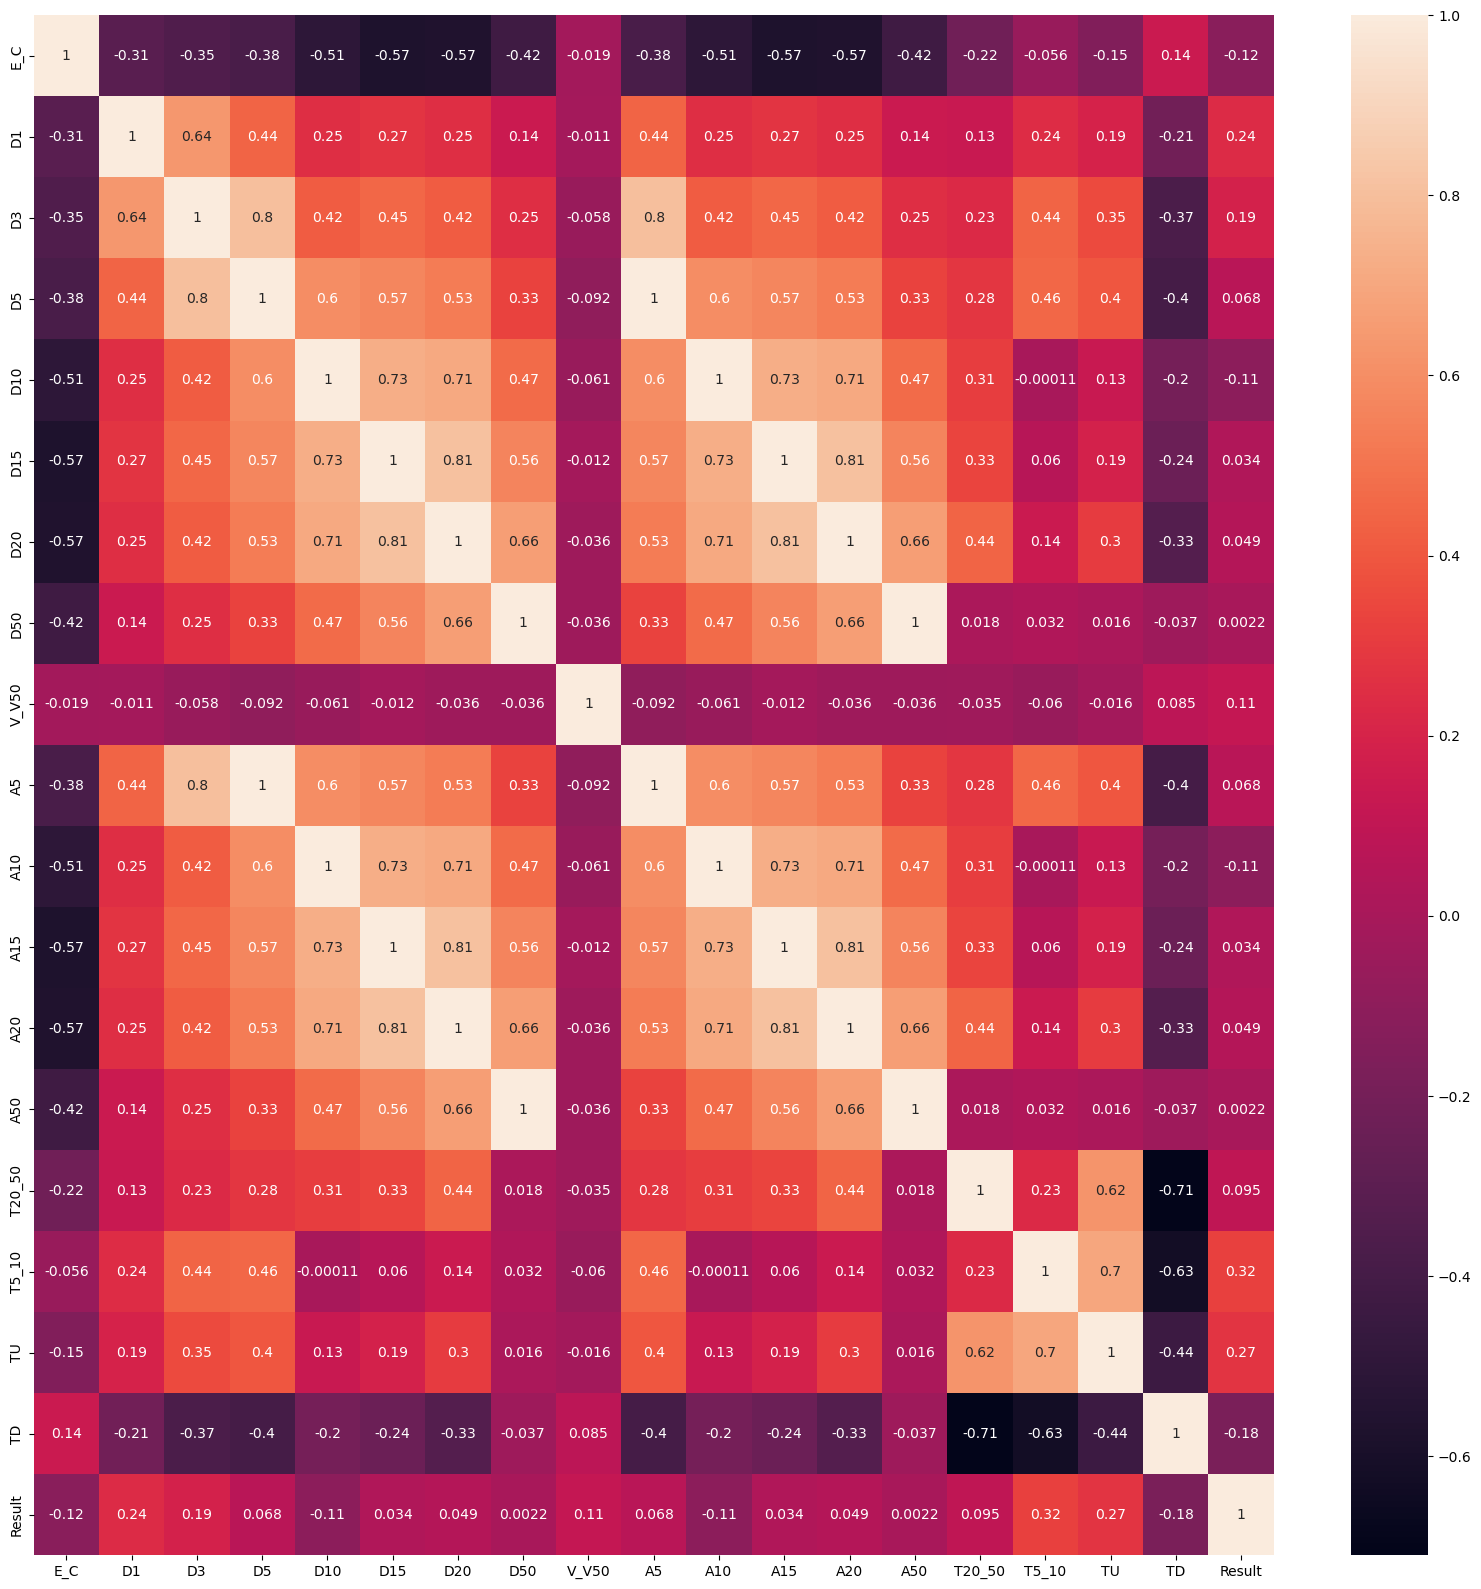

In [5]:
# Матрица корреляции
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()

Признаки, с которыми коррелирует целевая переменная

бинарные: T5_10, TU, TD
 

числовые: D1, D3, D10, V_v50, A10

### Бинарные признаки 

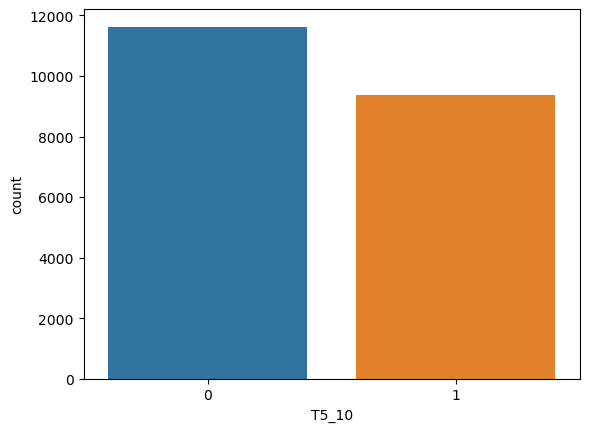

In [7]:
# распределение переменной T5_10
sns.countplot(x="T5_10", data=df)
plt.show()

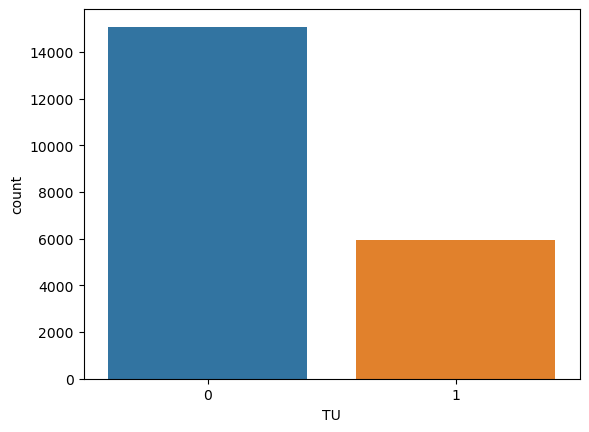

In [8]:
# распределение переменной TU
sns.countplot(x="TU", data=df)
plt.show()

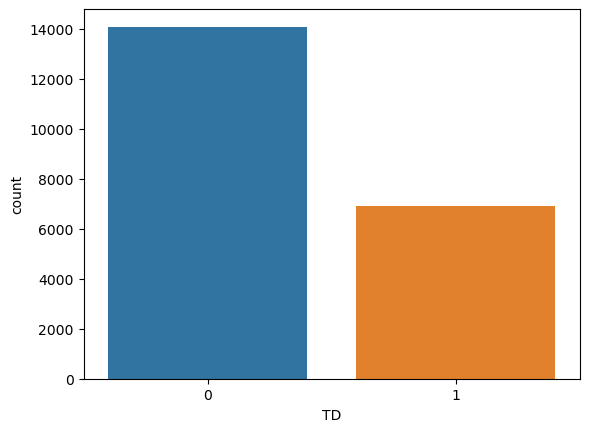

In [9]:
# распределение переменной TD
sns.countplot(x="TD", data=df)
plt.show()

Анализ распределения бинарных признаков позволяет делать вывод о том, что признаки TU и TD не сбалансированы.

D1

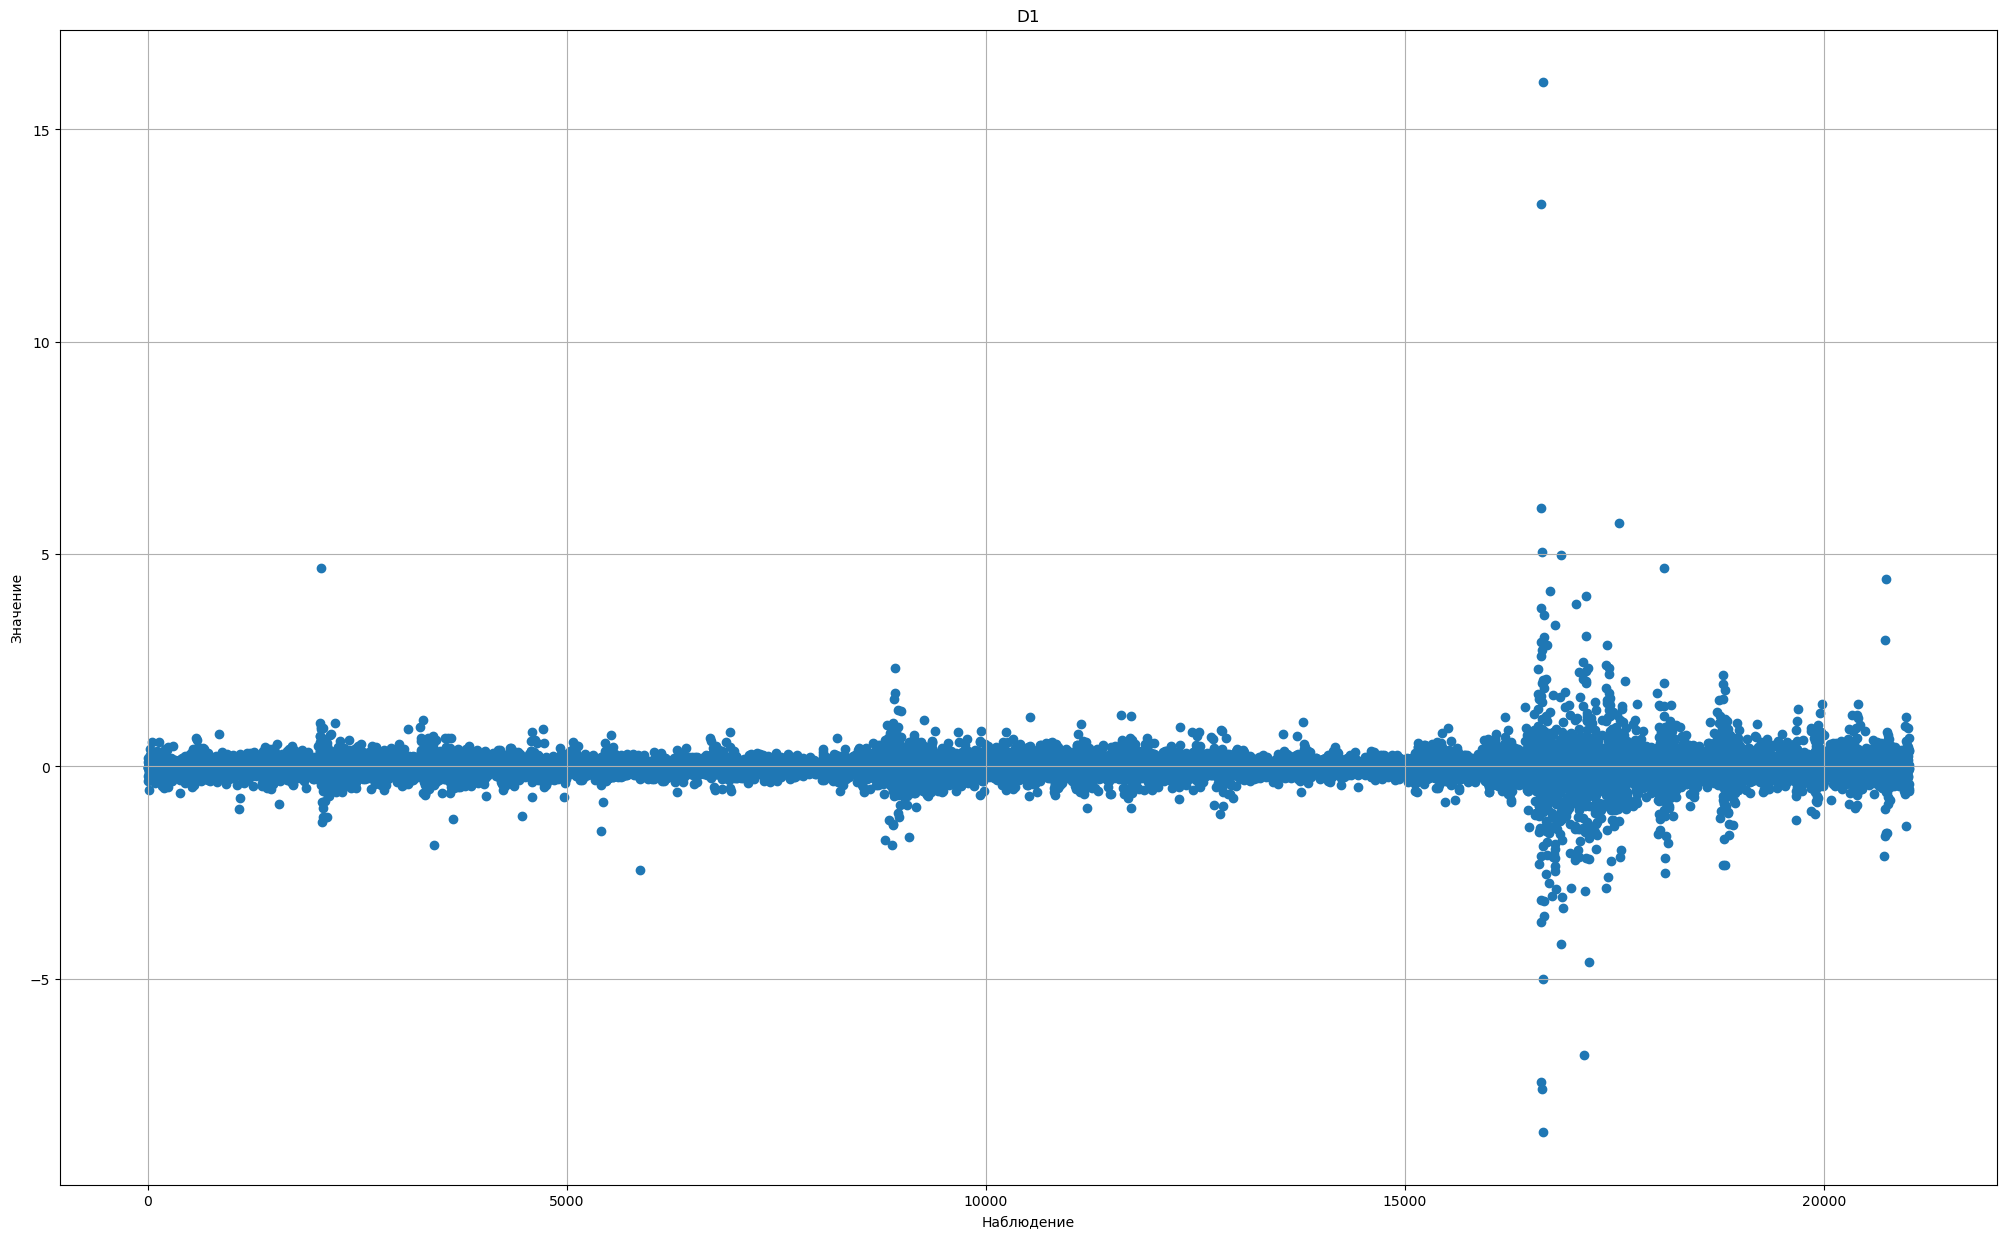

In [11]:
plt.ylabel("Значение")
plt.xlabel("Наблюдение")
plt.title("D1")
plt.grid()

plt.scatter(df.index, df['D1'])
plt.rcParams["figure.figsize"] = (25, 15)
plt.show()

<Axes: title={'center': 'Распределение переменной'}, xlabel='D1', ylabel='Density'>

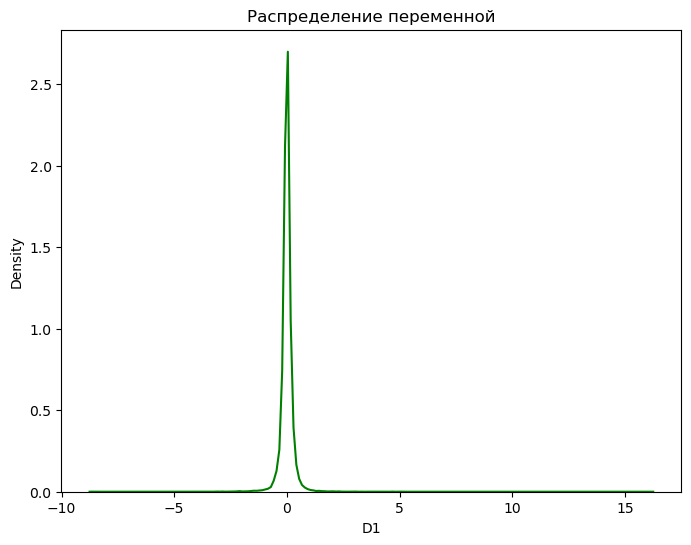

In [14]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 6))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D1'], color='green', ax = ax1)

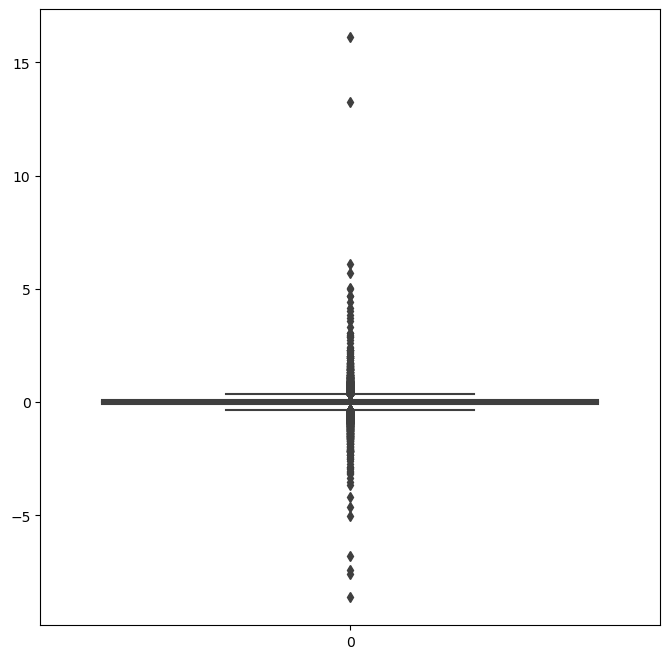

In [16]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['D1'], ax=ax)
plt.show()

Наблюдается высокая концентрация значений переменной вокруг 0. Дисперсия равна 0,35274. Присутствует большое количества выбросов.

D3

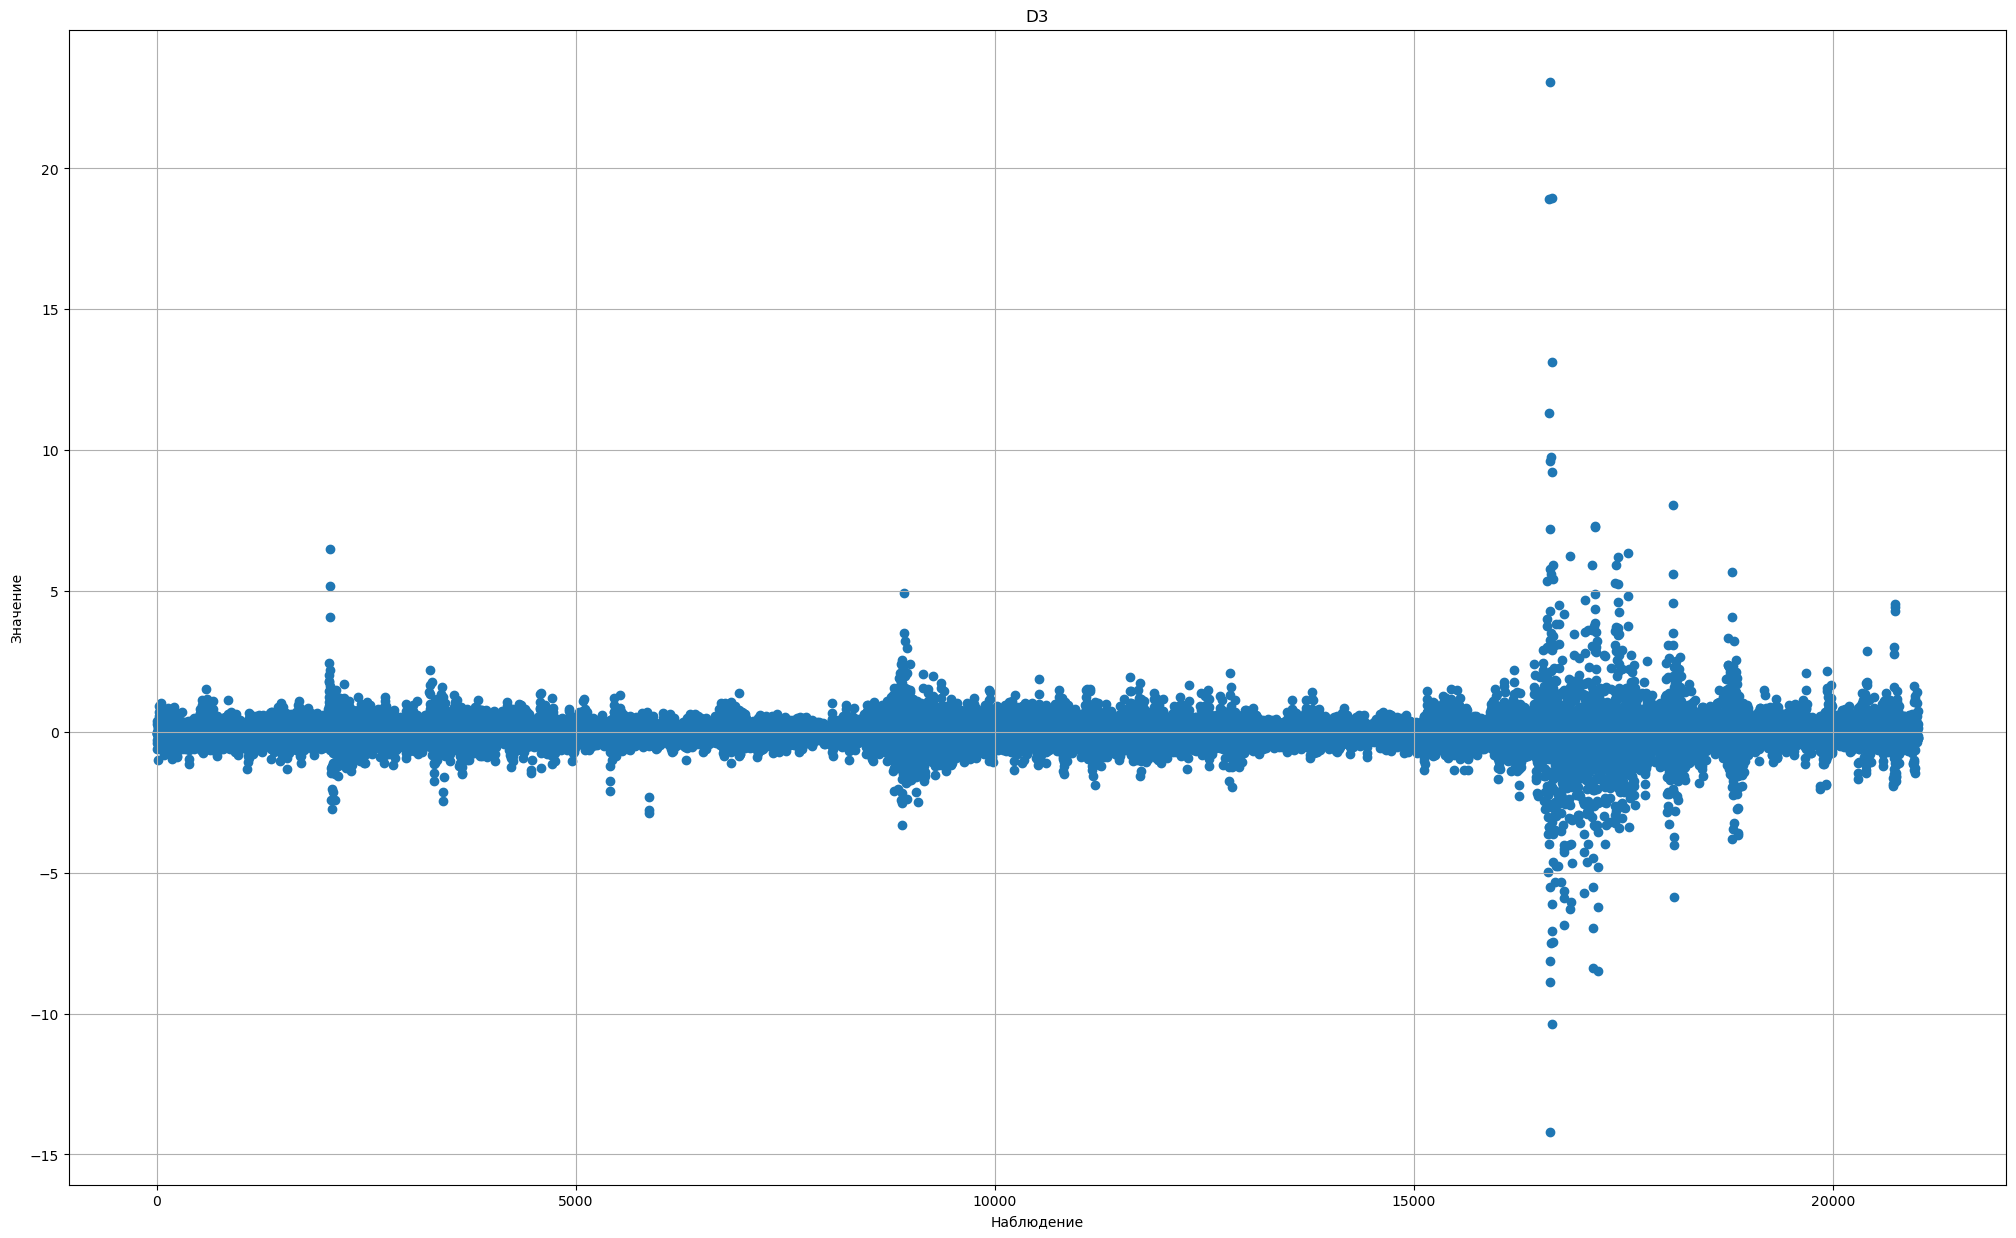

In [17]:
plt.ylabel("Значение")
plt.xlabel("Наблюдение")
plt.title("D3")
plt.grid()

plt.scatter(df.index, df['D3'])
plt.rcParams["figure.figsize"] = (25, 15)
plt.show()

<Axes: title={'center': 'Распределение переменной'}, xlabel='D3', ylabel='Density'>

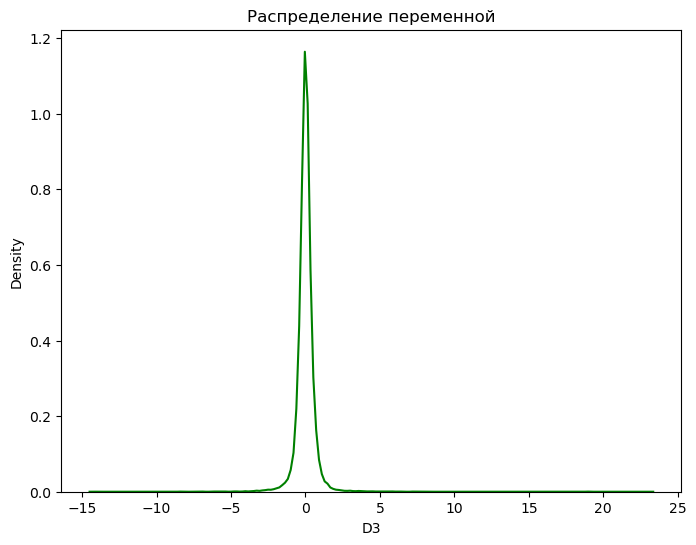

In [20]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 6))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D3'], color='green', ax = ax1)

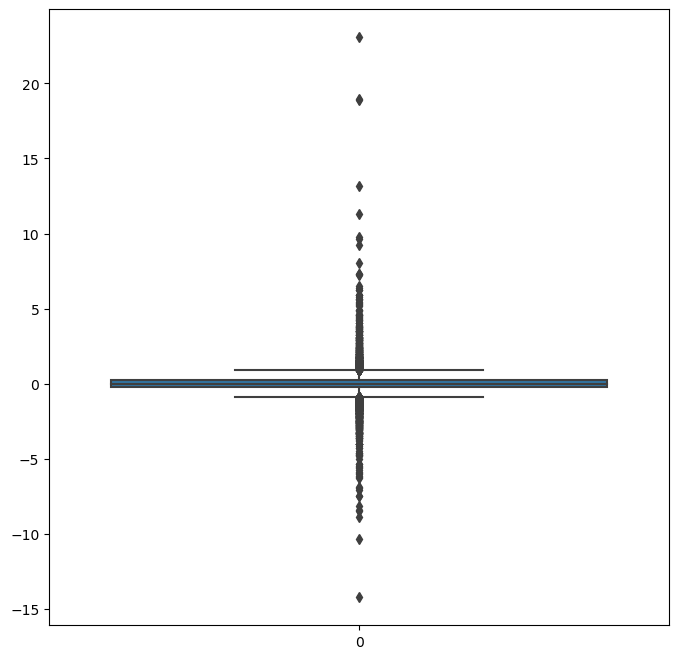

In [21]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['D3'], ax=ax)
plt.show()

Распределение переменной D3 схоже с распределением переменной D1. Также наблюдается высокая концентрация значений переменной вокруг 0. Дисперсия равна 0,70511. Присутствует большое количества выбросов.

D10

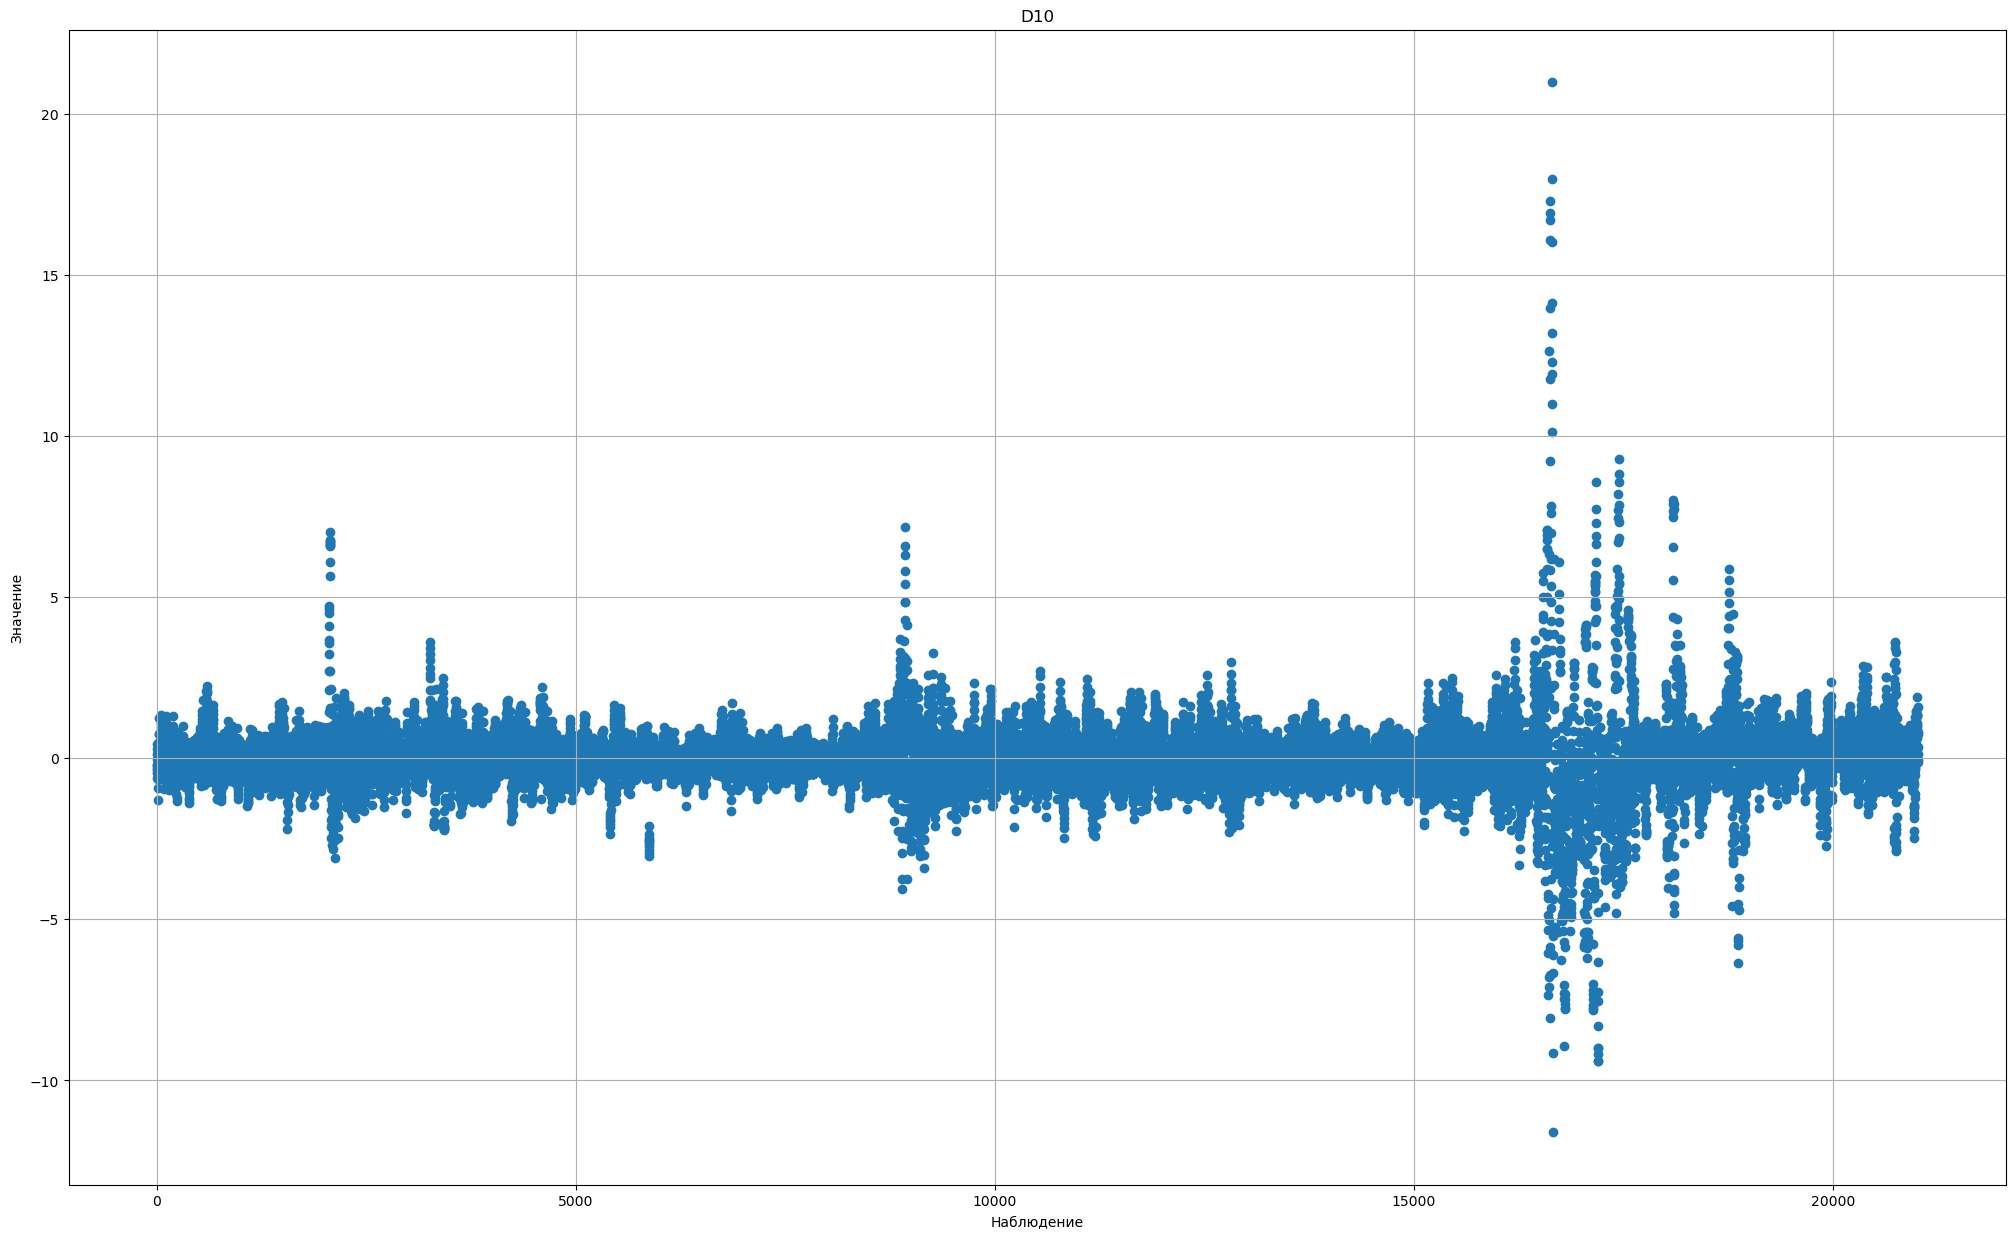

In [22]:
plt.ylabel("Значение")
plt.xlabel("Наблюдение")
plt.title("D10")
plt.grid()

plt.scatter(df.index, df['D10'])
plt.rcParams["figure.figsize"] = (25, 15)
plt.show()

<Axes: title={'center': 'Распределение переменной'}, xlabel='D10', ylabel='Density'>

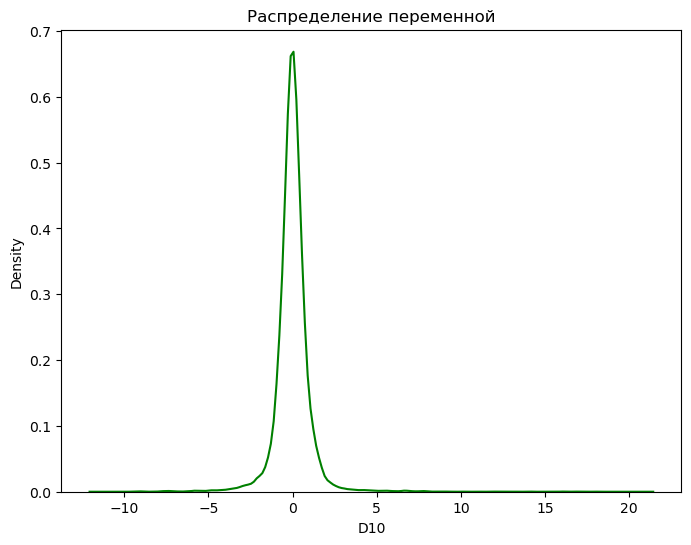

In [25]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 6))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D10'], color='green', ax = ax1)

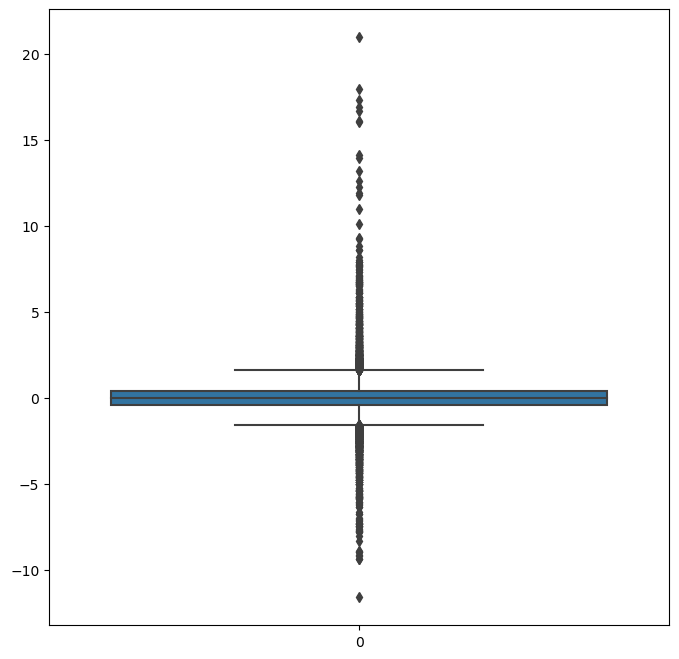

In [26]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['D10'], ax=ax)
plt.show()

Также наблюдается сходство с распределением предыдущих переменных. Однако можно наблюдать, что разброс значений выше, чем у предыдущих признаков. Дисперсия равна 1,09813.

V_V50

<Axes: title={'center': 'Распределение переменной'}, xlabel='V_V50', ylabel='Density'>

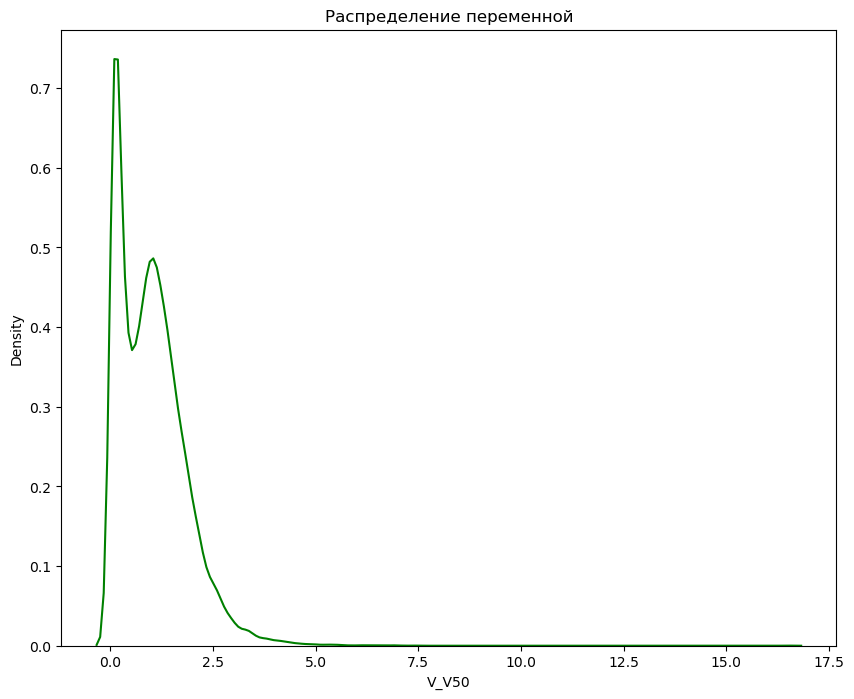

In [27]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['V_V50'], color='green', ax = ax1)

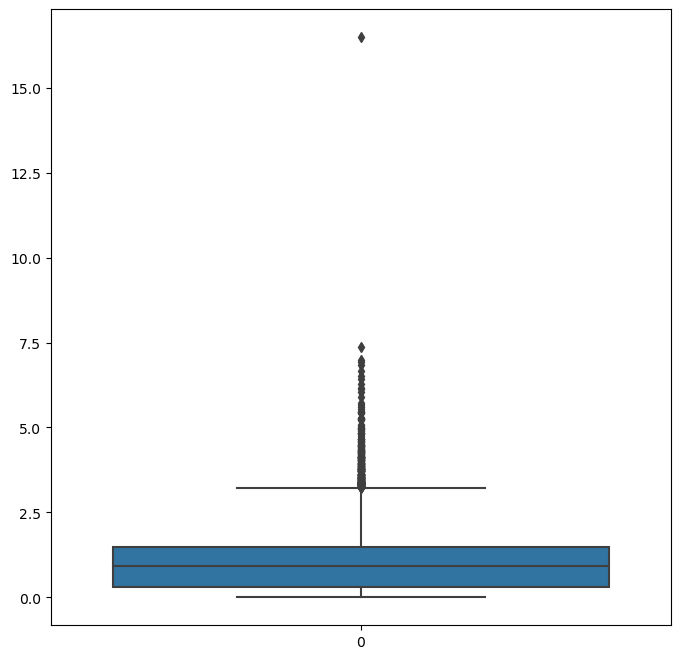

In [29]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['V_V50'], ax=ax)
plt.show()

В распределении переменной видим существенное смещение значений переменной вправо и также большое количество выбросов.

A10

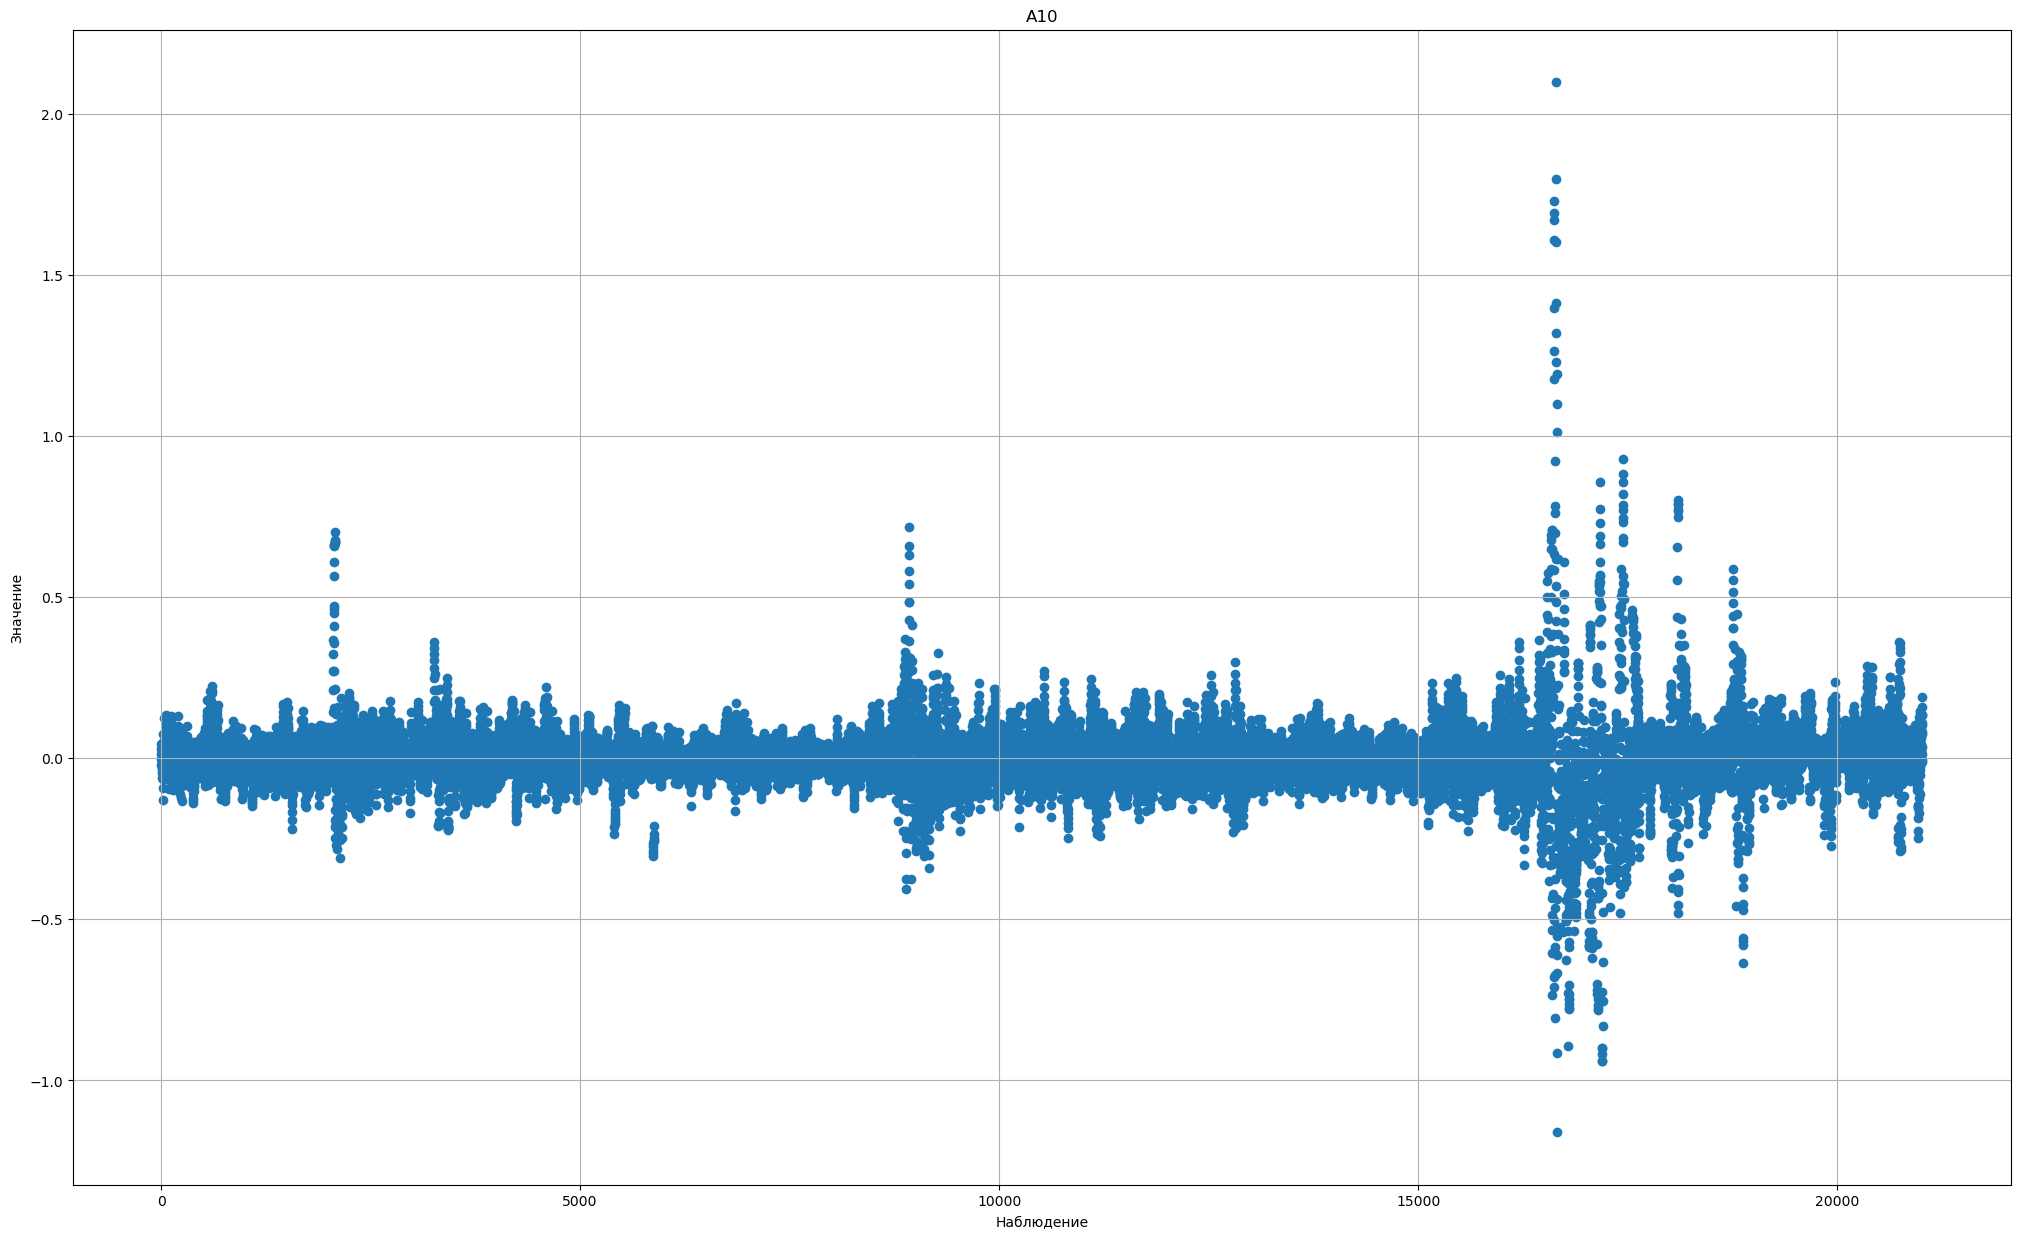

In [30]:
plt.ylabel("Значение")
plt.xlabel("Наблюдение")
plt.title("A10")
plt.grid()

plt.scatter(df.index, df['A10'])
plt.rcParams["figure.figsize"] = (25, 15)
plt.show()

<Axes: title={'center': 'Распределение переменной'}, xlabel='A10', ylabel='Density'>

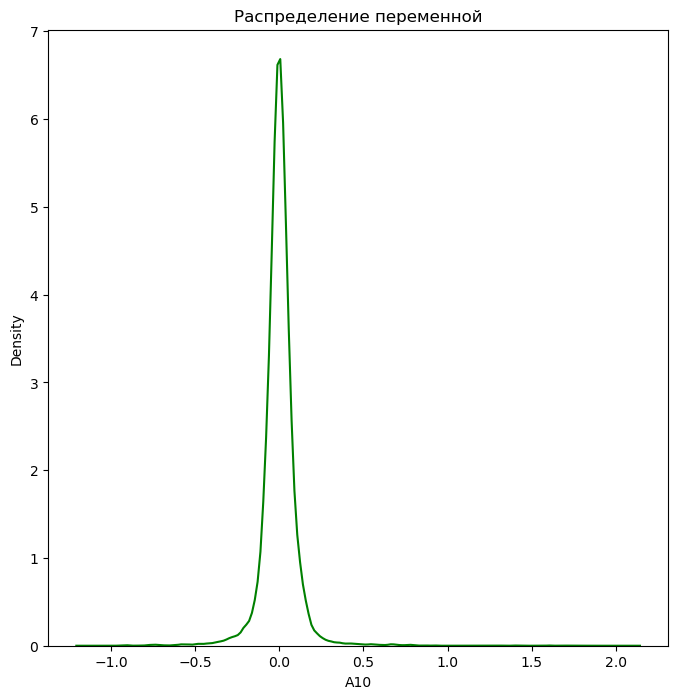

In [31]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['A10'], color='green', ax = ax1)

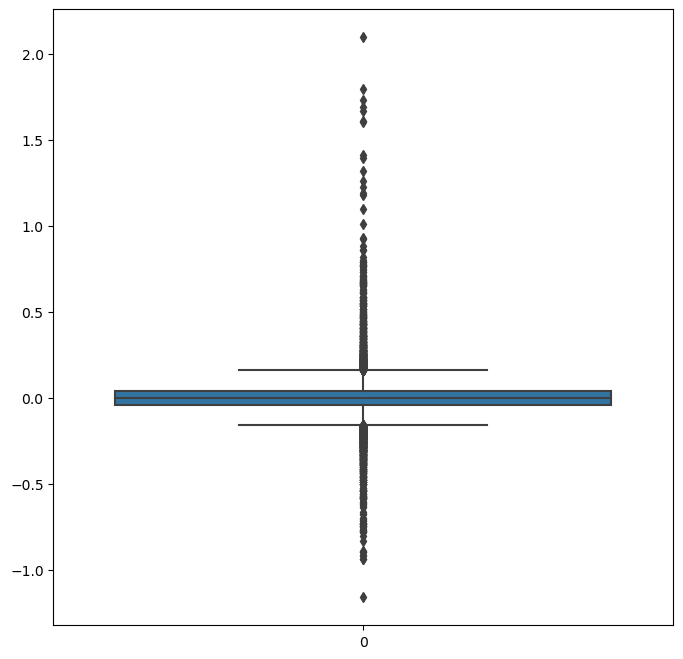

In [32]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['A10'], ax=ax)
plt.show()

Распределение переменной также схоже с распределением переменных типа D.

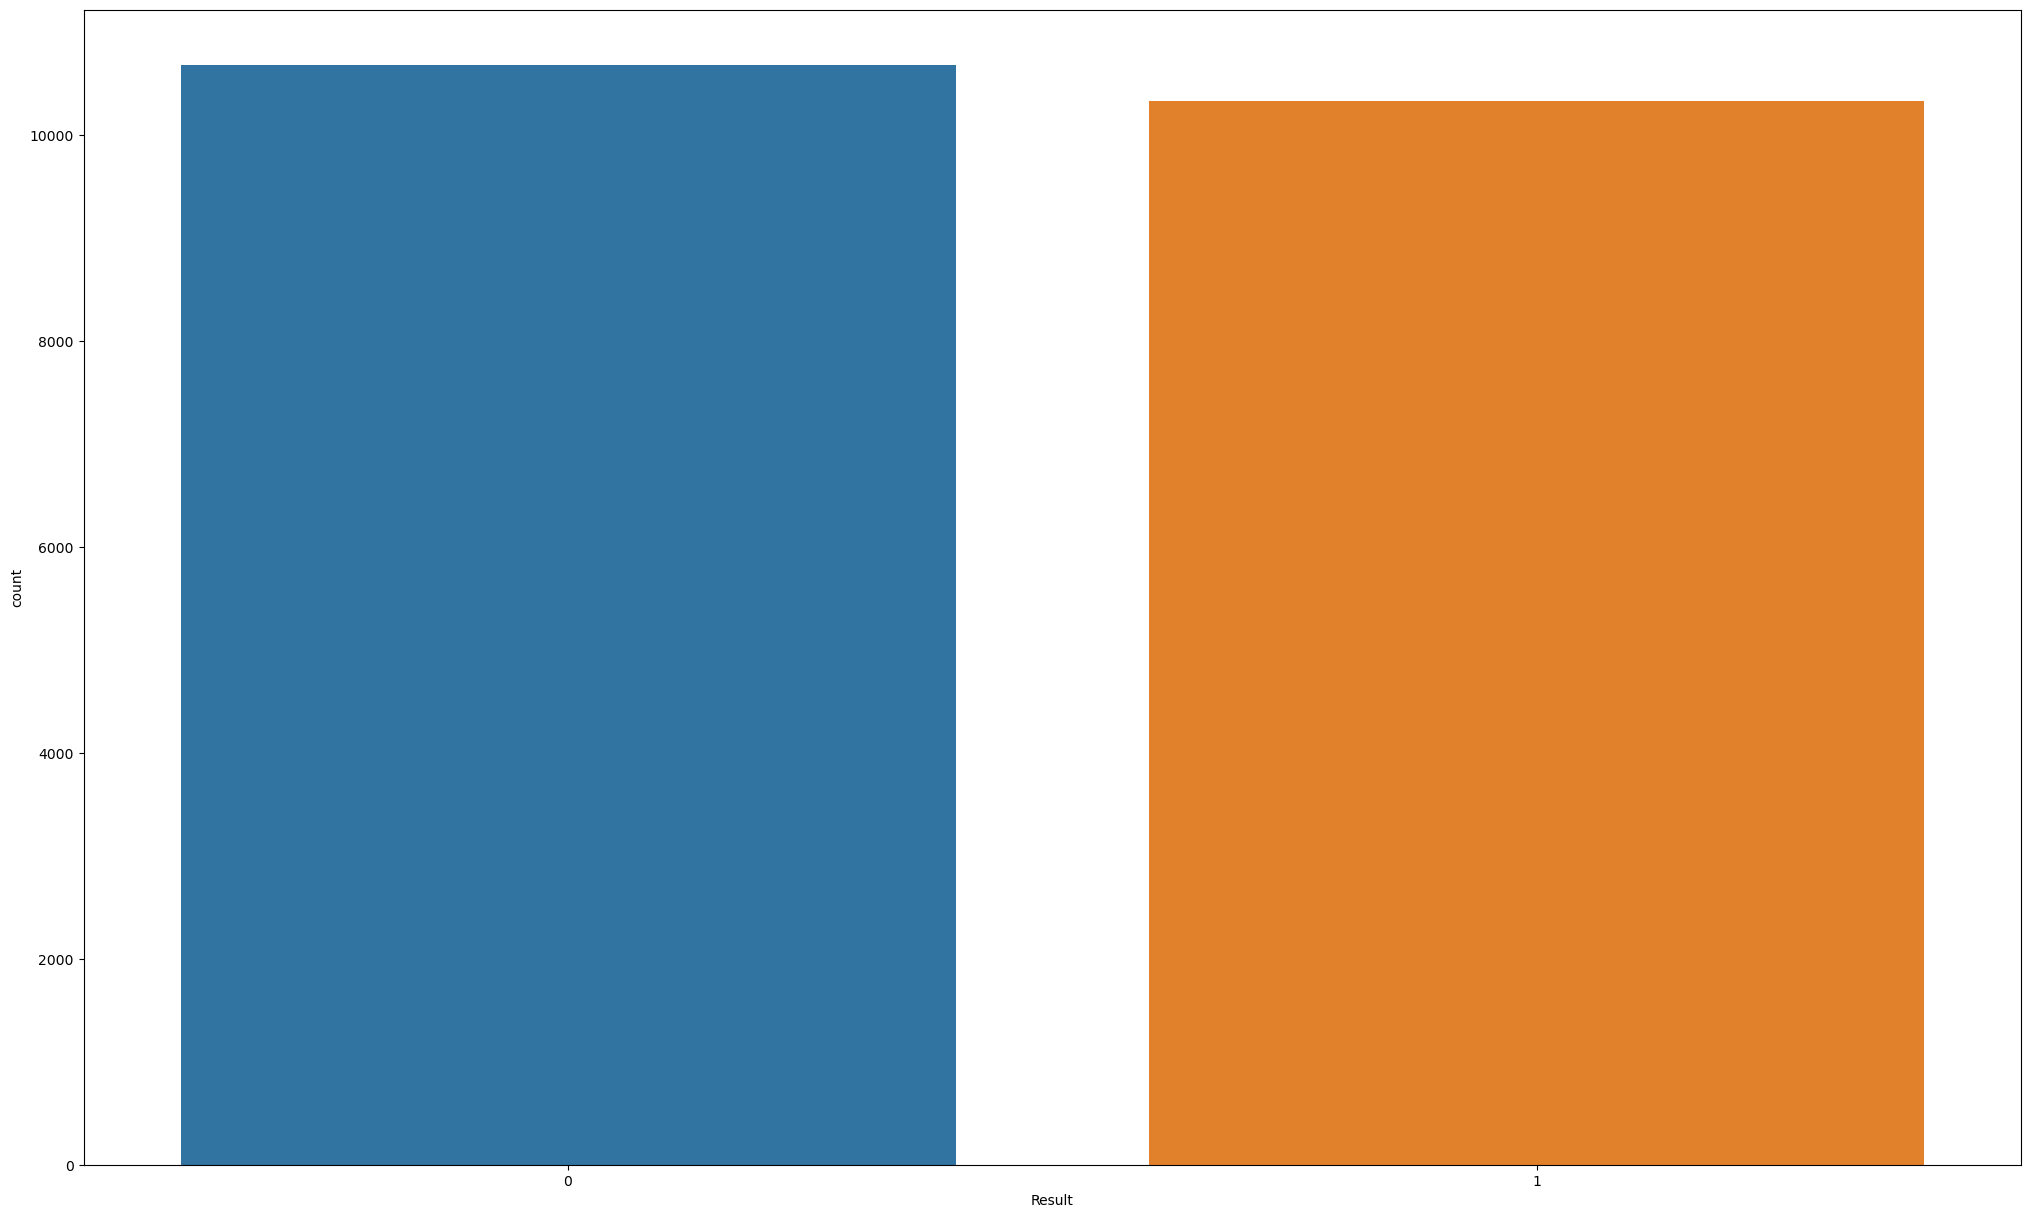

In [33]:
# пропорция целевой переменной
sns.countplot(x="Result", data=df)
plt.show()

Целевая переменная сбалансирована

# Обработка признаков

## Обработка выбросов

В датасете имеются выбросы. Их наличие являются не следствием ошибок при формирования датасета. 
Причина их появления заключается в аномально высокой валатильности валютного рынка в отдельных временных интервалах.
В связи с этим удалим наблюдения, где значения признаков превышают 3std от математического ожидания.

И рассмотрим как измениться распределение признаков после удаления выбросов

D1

In [34]:
# удаляем выбросы
lower_bound = df['D1'].mean()-3*df['D1'].std()
upper_bound = df['D1'].mean()+3*df['D1'].std()
df = df[(df.D1 < upper_bound) & (df.D1 > lower_bound)]
print(lower_bound, upper_bound)
print(df.shape)

-1.0573798720821053 1.059078769112939
(20749, 19)


<Axes: title={'center': 'Распределение переменной'}, xlabel='D1', ylabel='Density'>

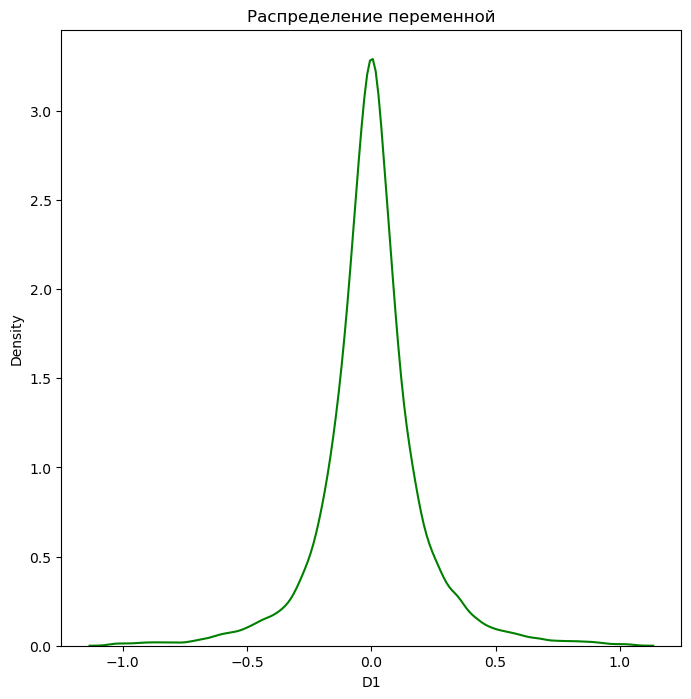

In [36]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D1'], color='green', ax = ax1)

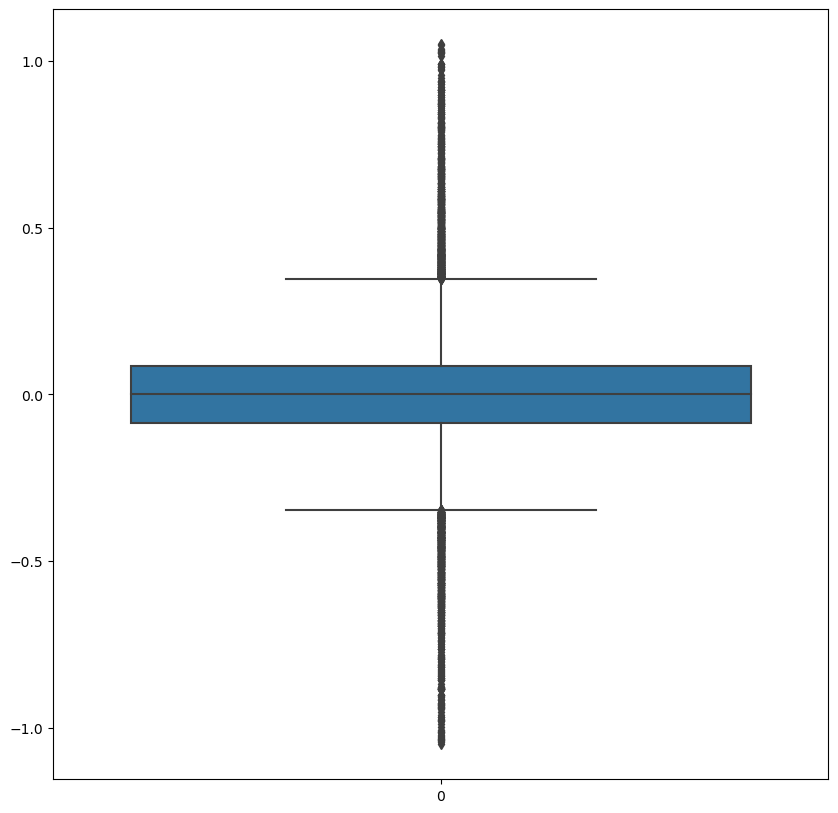

In [37]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(df['D1'], ax=ax)
plt.show()

D3

In [38]:
lower_bound = df['D3'].mean()-3*df['D3'].std()
upper_bound = df['D3'].mean()+3*df['D3'].std()
df = df[(df.D3 < upper_bound) & (df.D3 > lower_bound)]
print(lower_bound, upper_bound)
print(df.shape)

-1.595741989118997 1.622846722841104
(20449, 19)


<Axes: title={'center': 'Распределение переменной'}, xlabel='D3', ylabel='Density'>

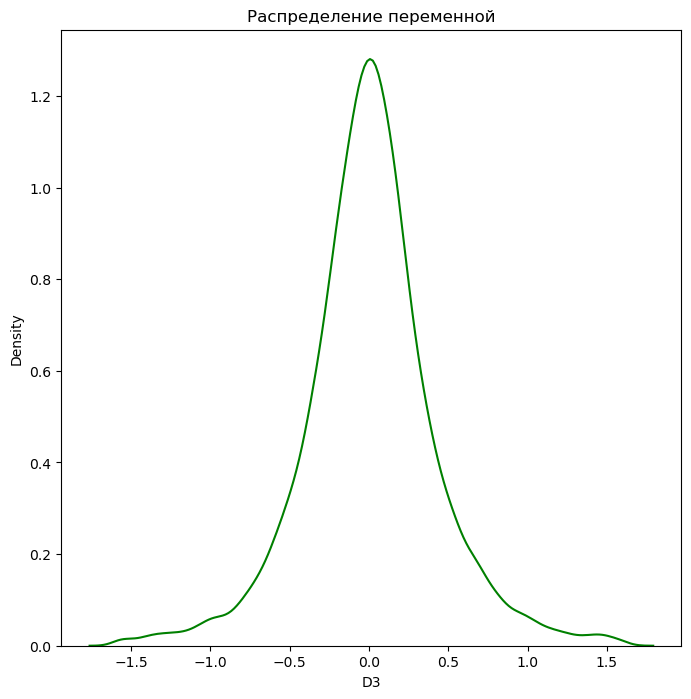

In [40]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D3'], color='green', ax = ax1)

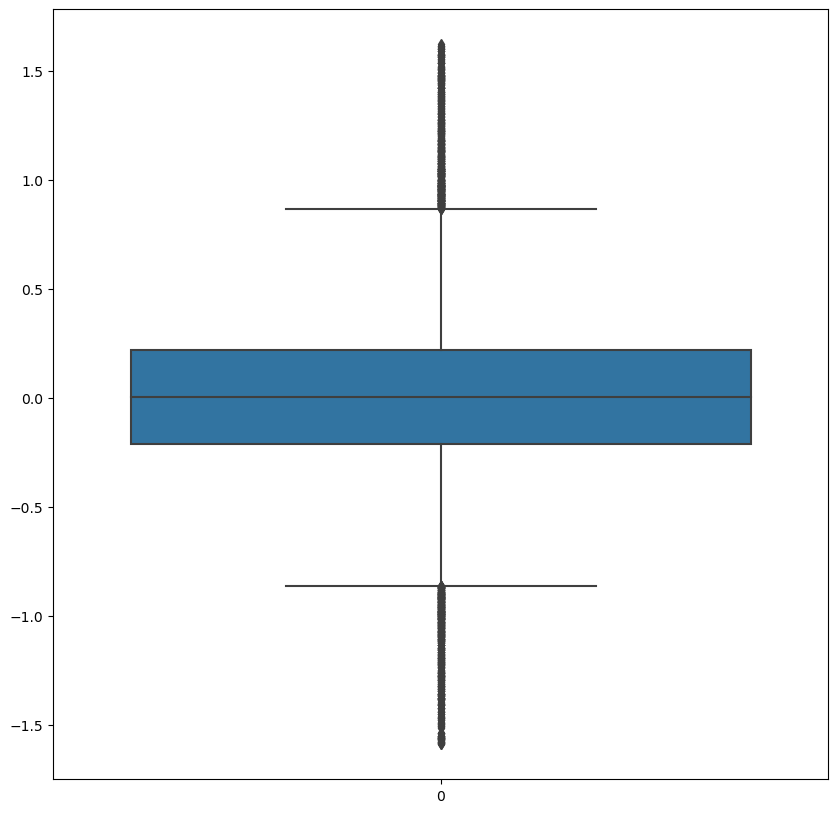

In [41]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(df['D3'], ax=ax)
plt.show()

Dinamic_pred10

In [42]:
lower_bound = df['D10'].mean()-3*df['D10'].std()
upper_bound = df['D10'].mean()+3*df['D10'].std()
df = df[(df.D10 < upper_bound) & (df.D10 > lower_bound)]
print(lower_bound, upper_bound)
print(df.shape)

-2.6362900942859553 2.657783089542447
(20138, 19)


<Axes: title={'center': 'Распределение переменной'}, xlabel='D10', ylabel='Density'>

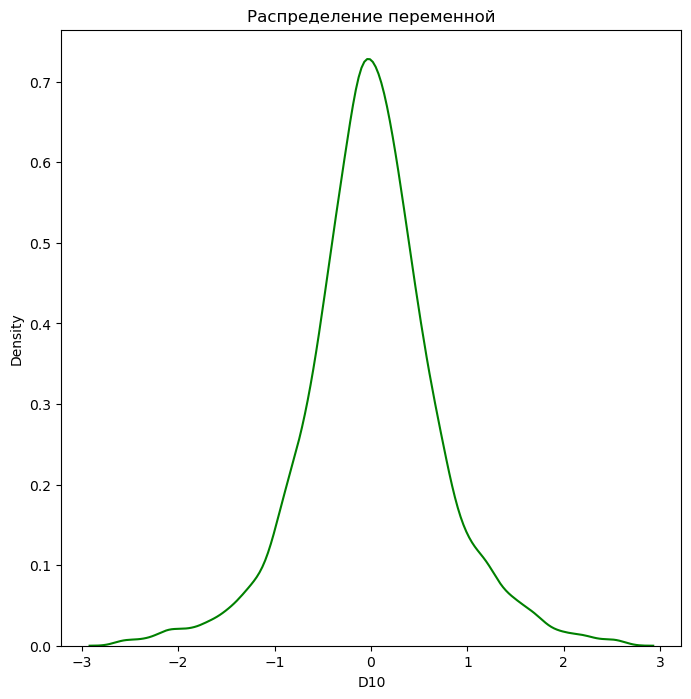

In [44]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['D10'], color='green', ax = ax1)

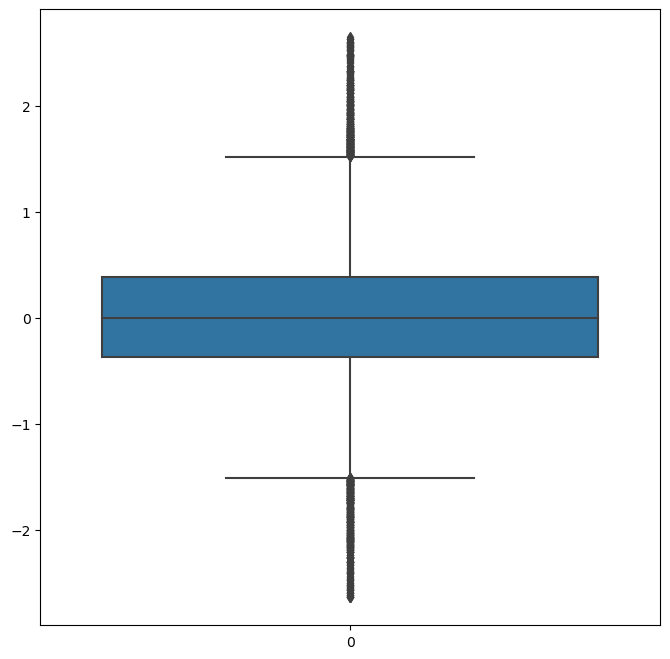

In [45]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['D10'], ax=ax)
plt.show()

vol_vol50

In [46]:
lower_bound = df['V_V50'].mean()-3*df['V_V50'].std()
upper_bound = df['V_V50'].mean()+3*df['V_V50'].std()
df = df[(df.V_V50 < upper_bound) & (df.V_V50 > lower_bound)]
print(lower_bound, upper_bound)
print(df.shape)

-1.4104016420909211 3.4001010511682868
(19930, 19)


<Axes: title={'center': 'Распределение переменной'}, xlabel='V_V50', ylabel='Density'>

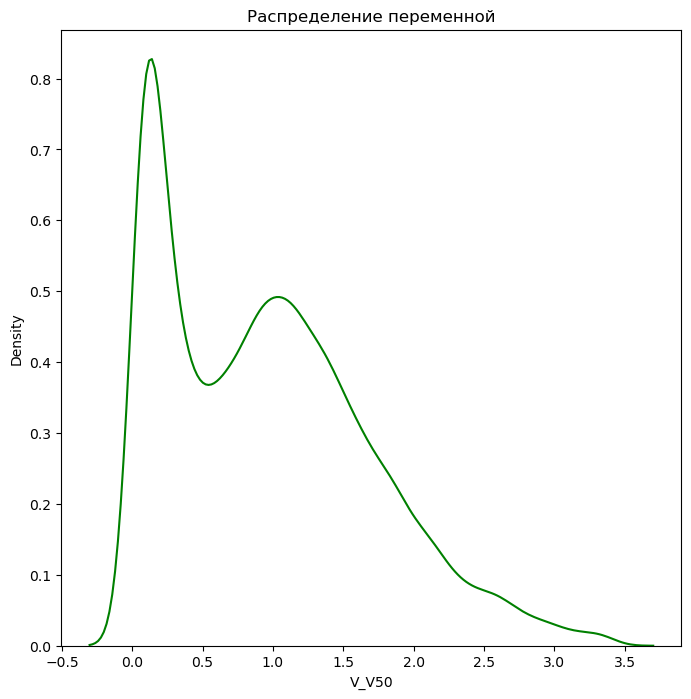

In [48]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (8, 8))
ax1.set_title('Распределение переменной')

sns.kdeplot(df['V_V50'], color='green', ax = ax1)

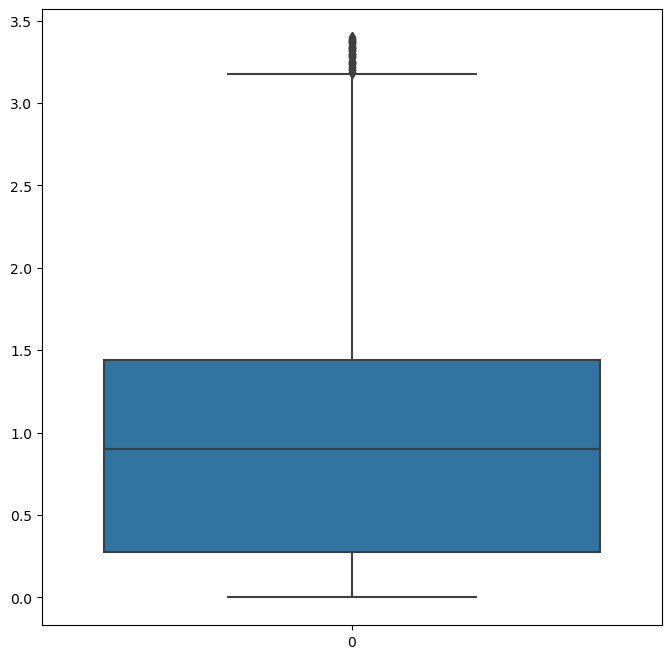

In [49]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(df['V_V50'], ax=ax)
plt.show()

## Стандартизация

In [50]:
X = df.drop(["Result"], axis=1)
y = df["Result"]

In [51]:
columns = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.51864816, -0.09592631, -0.02574531, ...,  1.11099277,
        -0.62994609, -0.69943028],
       [ 0.48083728, -0.09592631, -0.10118046, ..., -0.90009587,
        -0.62994609,  1.42973506],
       [ 0.19145223, -0.14276598, -0.16575789, ..., -0.90009587,
        -0.62994609,  1.42973506],
       ...,
       [-0.83654669,  2.11886701,  1.78430251, ..., -0.90009587,
        -0.62994609, -0.69943028],
       [ 0.17193369, -3.115736  , -0.54031195, ..., -0.90009587,
        -0.62994609, -0.69943028],
       [-0.08184095, -0.26688031, -0.59160785, ...,  1.11099277,
         1.58743744, -0.69943028]])

In [52]:
X_scaled = pd.DataFrame(data=X_scaled)
X_scaled.columns = columns
X_scaled.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD
0,0.518648,-0.095926,-0.025745,0.054074,-0.052537,-1.040665,-0.536967,-0.343821,-0.021112,0.054056,-0.052551,-1.040640,-0.537013,-0.343760,-1.016187,1.110993,-0.629946,-0.699430
1,0.480837,-0.095926,-0.101180,-0.037579,0.625410,-1.061490,-0.647977,-0.412420,-1.258763,-0.037579,0.625367,-1.061429,-0.647923,-0.412359,-1.016187,-0.900096,-0.629946,1.429735
2,0.191452,-0.142766,-0.165758,-0.113866,0.384371,-1.051131,-0.750324,-0.477166,0.662595,-0.113883,0.384429,-1.051214,-0.750288,-0.477229,-1.016187,-0.900096,-0.629946,1.429735
3,-0.034019,-0.212918,-0.219379,-0.205308,0.181258,-1.051382,-0.829125,-0.544170,0.134495,-0.205343,0.181244,-1.051393,-0.829198,-0.544088,-1.016187,-0.900096,-0.629946,1.429735
4,0.339185,-1.268699,-0.756897,-0.616634,-0.300820,-0.988906,-1.078119,-0.693308,0.981309,-0.616651,-0.300776,-0.988845,-1.078111,-0.693216,-1.016187,-0.900096,-0.629946,1.429735


# Обучение модели

In [55]:
print(X_scaled.shape)
print(y.shape)

(19930, 18)
(19930,)


In [56]:
# разделение на тестовую и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state=42)

In [57]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(15944, 18)
(15944,)
(3986, 18)
(3986,)


### LogisticRegression 

In [58]:

# logreg = LogisticRegression(max_iter=100,  random_state=0, verbose=1)
logreg = LogisticRegression(max_iter=100, penalty='l2', C=0.828642772,  random_state=0, verbose=1)
logreg.fit(X_train, y_train)
print('Точность на обучающей выборке ',logreg.score(X_train, y_train))
print('Точность на проверочной выборке ', logreg.score(X_test, y_test))

Точность на обучающей выборке  0.7800426492724536
Точность на проверочной выборке  0.7802308078273958


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
# подбор гиперпараметров логистической регрессии
# лучшие параметры {'C': 0.8286427728546842, 'penalty': 'l2'}


# logreg = LogisticRegression(max_iter=100, random_state=0, verbose=1)
# params_list = {'C': np.logspace(-4, 4, 50),
#                'penalty': ['l1', 'l2']}
# grid = GridSearchCV(logreg,param_grid=params_list,cv=5)
# model_grid = grid.fit(X_train,y_train)
# print(grid.best_params_)
# print('Точность на обучающей выборке ', grid.score(X_train, y_train))
# print('Точность на проверочной выборке ', grid.score(X_test, y_test))

In [ ]:
# результат подбора параметров
# result_df = pd.DataFrame.from_dict(grid.cv_results_, orient = 'columns')
# result_df

### KNeighborsClassifier

In [59]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=4, p=1, weights='distance')
knn.fit(X_train, y_train) #обучение
print('Точность на обучающей выборке ',knn.score(X_train, y_train))
print('Точность на проверочной выборке ', knn.score(X_test, y_test))

Точность на обучающей выборке  1.0
Точность на проверочной выборке  0.8294029101856498


In [9]:
# knn = KNeighborsClassifier()
# params_list = {'n_neighbors': [i for i in range (1, 5)],
#                'weights': ['uniform', 'distance'],
#                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                'leaf_size': [10, 20, 30, 40, 50],
#                 'p': [i for i in range (1, 3)]
#               }

# grid = GridSearchCV(knn,param_grid=params_list,cv=5)
# model_grid = grid.fit(X_train,y_train)

# print(grid.best_params_)
# # {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
# print('Точность на обучающей выборке ', grid.score(X_train, y_train))
# print('Точность на проверочной выборке ', grid.score(X_test, y_test))

###  RandomForest

In [60]:
rf = RandomForestClassifier(max_depth=None, max_features=7, min_samples_leaf=2, min_samples_split=2, n_estimators=200)
rf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print('Точность на обучающей выборке ',rf.score(X_train, y_train))
print('Точность на проверочной выборке ', rf.score(X_test, y_test))

Точность на обучающей выборке  0.9901530356246864
Точность на проверочной выборке  0.8682890115403914


In [14]:
# #подбор параметров
# rf = RandomForestClassifier()
# grid_space={'max_depth':[None],
#             'n_estimators':[10,100,200],
#             'max_features':[1,3,5,7],
#             'min_samples_leaf':[1,2,3],
#             'min_samples_split':[1,2,3]
#            }
# grid = GridSearchCV(rf,param_grid=grid_space,cv=5)
# model_grid = grid.fit(X_train,y_train)
# print(grid.best_params_)
# print('Точность на обучающей выборке ', grid.score(X_train, y_train))
# print('Точность на проверочной выборке ', grid.score(X_test, y_test))

Сохраняем лушую модель в файл pickle

In [63]:
 # Save to file in the current working directory 
 pkl_filename = "pickle_model.pkl" 
 with open(pkl_filename, 'wb') as file: 
     pickle.dump(rf, file)

### Stochastic Gradient Descent 

In [61]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print('Точность на обучающей выборке ',clf.score(X_train, y_train))
print('Точность на проверочной выборке ', clf.score(X_test, y_test))

Точность на обучающей выборке  0.7625439036628199
Точность на проверочной выборке  0.7649272453587557


### Support Vector Machine 

In [62]:
SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print('Точность на обучающей выборке ',SVM.score(X_train, y_train))
print('Точность на проверочной выборке ', SVM.score(X_test, y_test))

Точность на обучающей выборке  0.7772829904666332
Точность на проверочной выборке  0.7747114902157551


C:\Users\Aleksandr-2\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Нейронная сеть 

In [64]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
%matplotlib inline

In [65]:
df.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD,Result
0,0.30163,-0.01743,-0.00436,0.04796,-0.02509,-0.85772,-0.57555,-0.66612,0.94634,0.00959,-0.00251,-0.05718,-0.02878,-0.01332,0,1,0,0,0
1,0.27912,-0.01743,-0.03486,-0.00435,0.44003,-0.87515,-0.69766,-0.80412,0.03890,-0.00087,0.04400,-0.05834,-0.03488,-0.01608,0,0,0,1,0
2,0.10684,-0.02611,-0.06097,-0.04789,0.27466,-0.86648,-0.81024,-0.93437,1.44763,-0.00958,0.02747,-0.05777,-0.04051,-0.01869,0,0,0,1,0
3,-0.02739,-0.03911,-0.08265,-0.10008,0.13531,-0.86669,-0.89692,-1.06916,1.06043,-0.02002,0.01353,-0.05778,-0.04485,-0.02138,0,0,0,1,0
4,0.19479,-0.23476,-0.29998,-0.33484,-0.19543,-0.81440,-1.17081,-1.36918,1.68131,-0.06697,-0.01954,-0.05429,-0.05854,-0.02738,0,0,0,1,0


In [66]:
X, y = df.values[:, :-1], df.values[:, -1]
X = X.astype('float32')
y = LabelEncoder().fit_transform(y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
n_features = X.shape[1] 
model = Sequential()

# скрытые слои
# 20 - количество нейронов
model.add(Dense(20, activation='relu', input_shape = (n_features,)))
model.add(Dense(10, activation='relu'))
          
# выходной слой должен иметь количество нейронов, равное количесту классов. в бинарной классификации один нейрон, 
# который возвращает 0 или 1
model.add(Dense(1, activation = 'sigmoid'))

# компилируем модели
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
# обучение модели
# объект history создаем для визуализации процесса обучения
# batch_size кусок данных, который даем нейронной сети для обучения
# epochs количество раз сколько модель пройдет по всем данным
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   verbose = 1,
                   validation_data = (X_test, y_test))

predictions = (model.predict(X_test) > 0.5).astype("int32")
# Валидируем наш прогноз
score = accuracy_score(y_test, predictions)

print("Accuracy:", score)


Epoch 1/20
499/499 [==============================] - 1s 2ms/step - loss: 0.5508 - val_loss: 0.4730
Epoch 2/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4554 - val_loss: 0.4485
Epoch 3/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4385 - val_loss: 0.4385
Epoch 4/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4302 - val_loss: 0.4289
Epoch 5/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4238 - val_loss: 0.4229
Epoch 6/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4173 - val_loss: 0.4155
Epoch 7/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4101 - val_loss: 0.4129
Epoch 8/20
499/499 [==============================] - 1s 1ms/step - loss: 0.4038 - val_loss: 0.4067
Epoch 9/20
499/499 [==============================] - 1s 1ms/step - loss: 0.3977 - val_loss: 0.4013
Epoch 10/20
499/499 [==============================] - 1s 1ms/step - loss: 0.3917 - val_loss: 0.3991

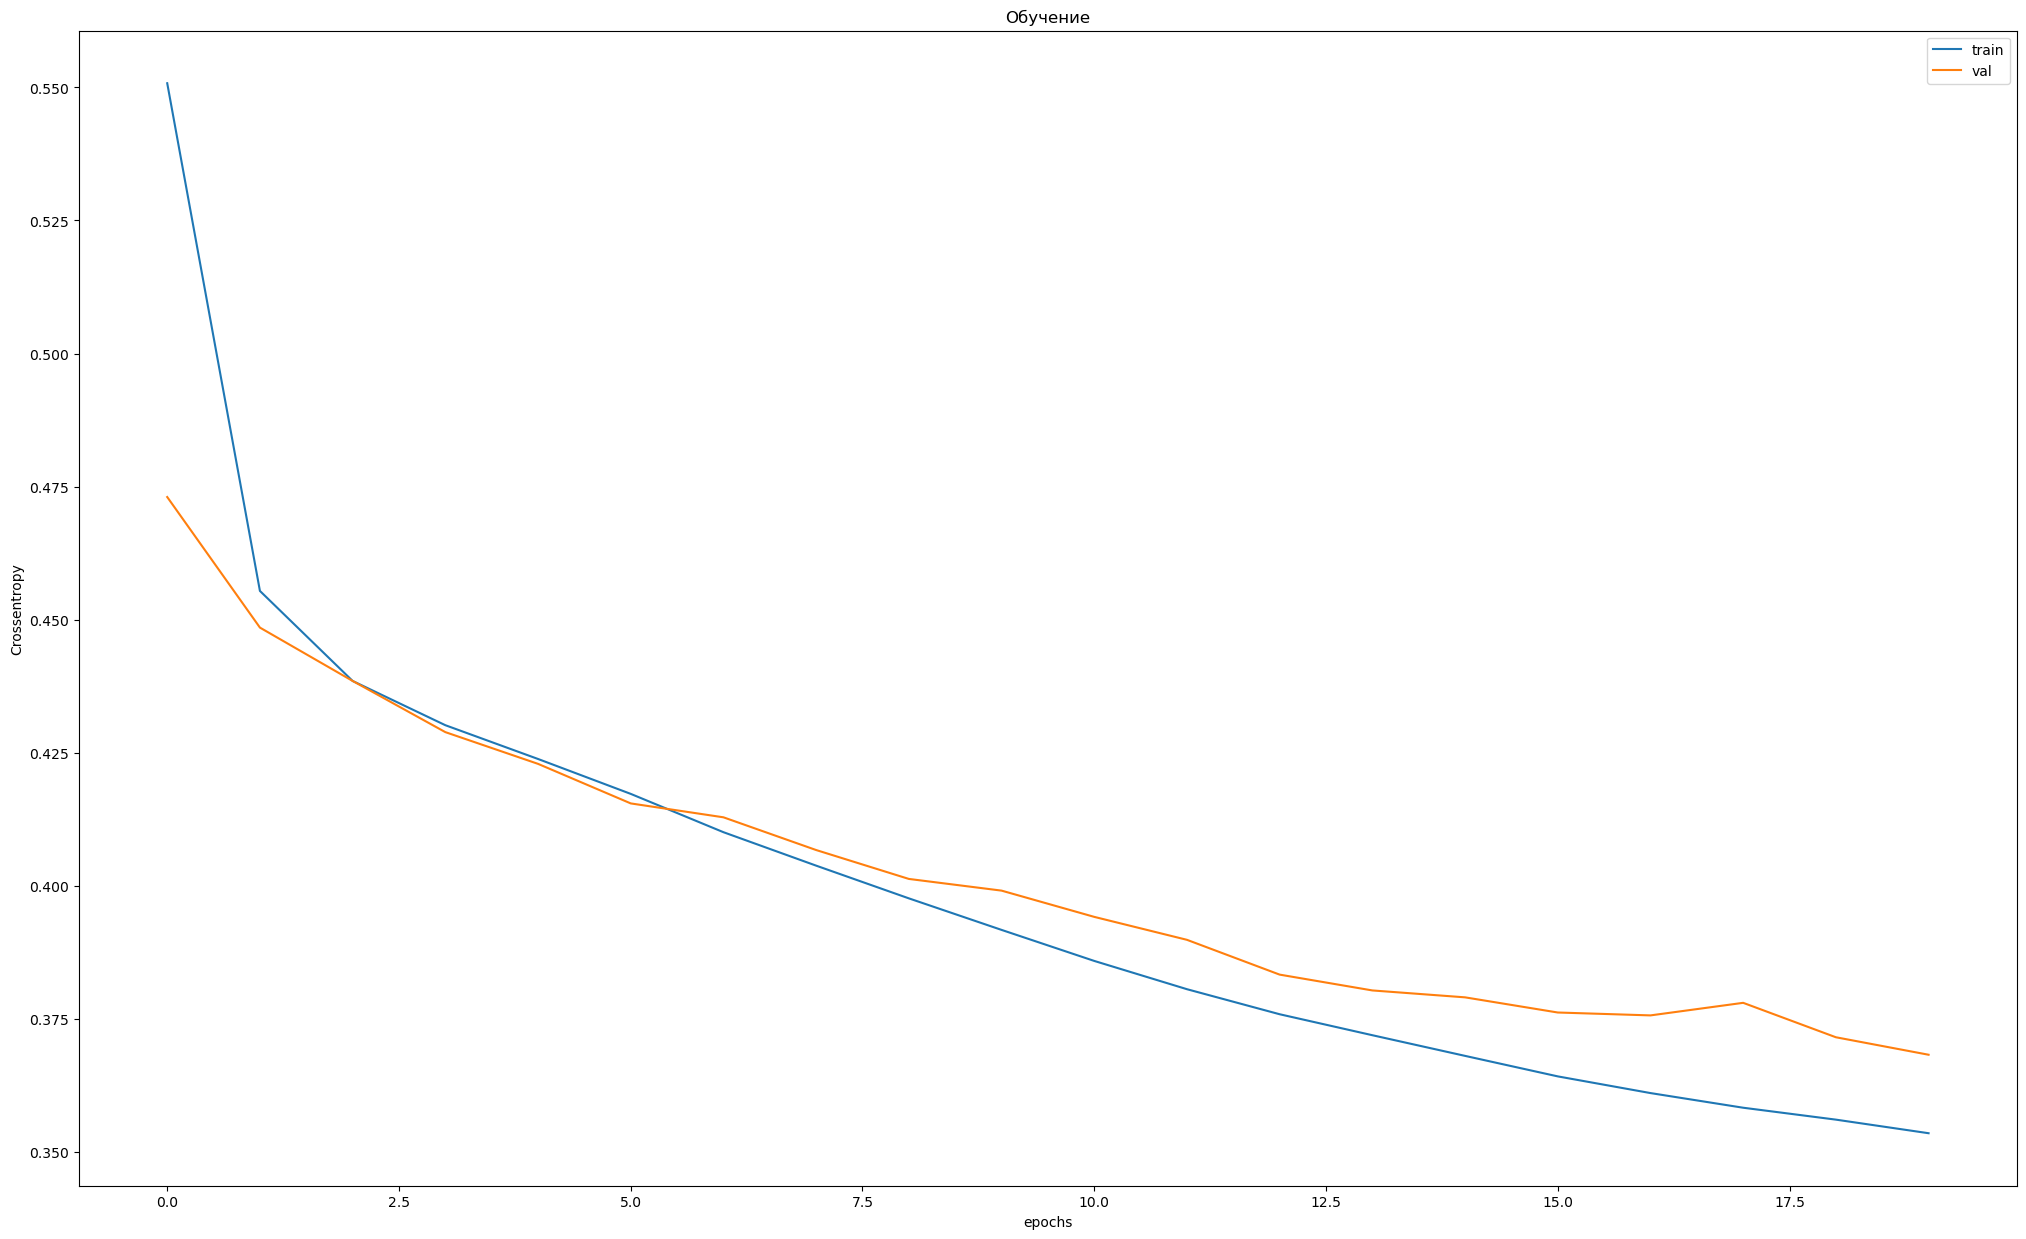

In [68]:
# # визуализация процесса обучения
pyplot.title('Обучение')
pyplot.xlabel('epochs')
pyplot.ylabel('Crossentropy')
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'val')
pyplot.legend()
pyplot.show()

# Оценка результатов

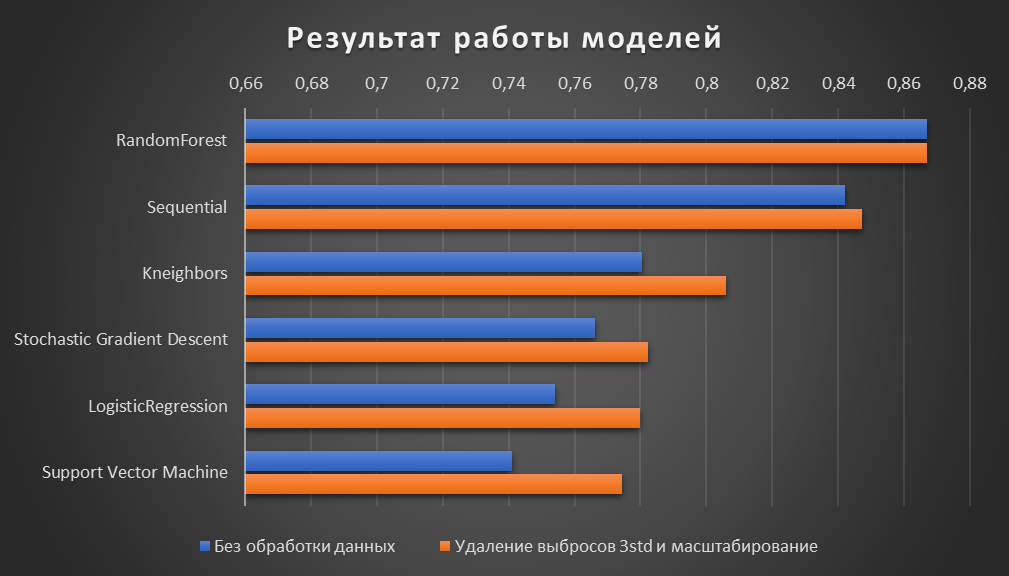

Наилучший результат показала модель RandomForest, а также нейронная сеть.

Причем результат RandomForest никак не зависит от стандартизации и удаления выбросов.


# Проверка на диапазонах

Также представляет интерес проверка работы модели на разных интервалах выборки.

С этой целью последовательно в тестовую выборку помещался диапазон 
наблюдений с 0 по 1000, с 1000 по 2000 и так далее. 

Эти же диапазоны исключались из обучающей выборки.


In [78]:
path = 'USD_dopfiatures_totest.csv'
df = pd.read_csv(path, sep=';', decimal = ',')
df = df.drop(['DATE', 'TIME'], axis = 1)
df.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD,Result
0,0.30163,-0.01743,-0.00436,0.04796,-0.02509,-0.85772,-0.57555,-0.66612,0.94634,0.00959,-0.00251,-0.05718,-0.02878,-0.01332,0,1,0,0,0
1,0.27912,-0.01743,-0.03486,-0.00435,0.44003,-0.87515,-0.69766,-0.80412,0.03890,-0.00087,0.04400,-0.05834,-0.03488,-0.01608,0,0,0,1,0
2,0.10684,-0.02611,-0.06097,-0.04789,0.27466,-0.86648,-0.81024,-0.93437,1.44763,-0.00958,0.02747,-0.05777,-0.04051,-0.01869,0,0,0,1,0
3,-0.02739,-0.03911,-0.08265,-0.10008,0.13531,-0.86669,-0.89692,-1.06916,1.06043,-0.02002,0.01353,-0.05778,-0.04485,-0.02138,0,0,0,1,0
4,0.19479,-0.23476,-0.29998,-0.33484,-0.19543,-0.81440,-1.17081,-1.36918,1.68131,-0.06697,-0.01954,-0.05429,-0.05854,-0.02738,0,0,0,1,0


## рассмотрим сначало точность работы модели на первом диапазоне

In [72]:
s = 1000
f = 2000

In [70]:
X1 = df.drop(["Result"], axis=1)
y1 = df["Result"]
X_train = X1.drop(X1.loc[s:f].index)
X_test = X1.iloc[s:f]
y_train = y1.drop(y1.loc[s:f].index)
y_test = y1.iloc[s:f] 

In [71]:
rf = RandomForestClassifier(max_depth=None, max_features=7, min_samples_leaf=2, min_samples_split=2, n_estimators=200)
rf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print('Точность на обучающей выборке ',rf.score(X_train, y_train))
print('Точность на проверочной выборке ', rf.score(X_test, y_test))

Точность на обучающей выборке  0.9911864048976146
Точность на проверочной выборке  0.905


Точность давольно высокая

## а теперь сравним с результатом на последнем диапазоне

In [ ]:
path = 'USD_dopfiatures_totest.csv'
df = pd.read_csv(path, sep=';', decimal = ',')
df = df.drop(['DATE', 'TIME'], axis = 1)
df.head()

In [79]:
s = 20000
f = 21000

In [80]:
X1 = df.drop(["Result"], axis=1)
y1 = df["Result"]
X_train = X1.drop(X1.loc[s:f].index)
X_test = X1.iloc[s:f]
y_train = y1.drop(y1.loc[s:f].index)
y_test = y1.iloc[s:f] 

In [81]:
rf = RandomForestClassifier(max_depth=None, max_features=7, min_samples_leaf=2, min_samples_split=2, n_estimators=200)
rf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print('Точность на обучающей выборке ',rf.score(X_train, y_train))
print('Точность на проверочной выборке ', rf.score(X_test, y_test))

Точность на обучающей выборке  0.9906070447164627
Точность на проверочной выборке  0.498


Точность около 50 говорит о том, что модель фактически не работает

## Проведем аналогичный тест с нейронной сетью 

In [82]:
path = 'USD_dopfiatures_totest.csv'
df = pd.read_csv(path, sep=';', decimal = ',')
df = df.drop(['DATE', 'TIME'], axis = 1)
df.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD,Result
0,0.30163,-0.01743,-0.00436,0.04796,-0.02509,-0.85772,-0.57555,-0.66612,0.94634,0.00959,-0.00251,-0.05718,-0.02878,-0.01332,0,1,0,0,0
1,0.27912,-0.01743,-0.03486,-0.00435,0.44003,-0.87515,-0.69766,-0.80412,0.03890,-0.00087,0.04400,-0.05834,-0.03488,-0.01608,0,0,0,1,0
2,0.10684,-0.02611,-0.06097,-0.04789,0.27466,-0.86648,-0.81024,-0.93437,1.44763,-0.00958,0.02747,-0.05777,-0.04051,-0.01869,0,0,0,1,0
3,-0.02739,-0.03911,-0.08265,-0.10008,0.13531,-0.86669,-0.89692,-1.06916,1.06043,-0.02002,0.01353,-0.05778,-0.04485,-0.02138,0,0,0,1,0
4,0.19479,-0.23476,-0.29998,-0.33484,-0.19543,-0.81440,-1.17081,-1.36918,1.68131,-0.06697,-0.01954,-0.05429,-0.05854,-0.02738,0,0,0,1,0


In [83]:
s = 1000
f = 2000

In [85]:
train = df.drop(df.loc[s:f].index)
test = df.iloc[s:f]

X_train, y_train = train.values[:, :-1], train.values[:, -1]
X_train = X_train.astype('float32')
y_train = LabelEncoder().fit_transform(y_train)

X_test, y_test = test.values[:, :-1], test.values[:, -1]
X_test = X_test.astype('float32')
y_test = LabelEncoder().fit_transform(y_test)

In [86]:
n_features = X.shape[1] 
model = Sequential()

model.add(Dense(20, activation='relu', input_shape = (n_features,)))
model.add(Dense(10, activation='relu'))
          
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   verbose = 1,
                   validation_data = (X_test, y_test))

predictions = (model.predict(X_test) > 0.5).astype("int32")
score = accuracy_score(y_test, predictions)

print("Accuracy:", score)

Epoch 1/20
626/626 [==============================] - 1s 1ms/step - loss: 0.5704 - val_loss: 0.4335
Epoch 2/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4729 - val_loss: 0.3663
Epoch 3/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4443 - val_loss: 0.3300
Epoch 4/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4265 - val_loss: 0.3169
Epoch 5/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4135 - val_loss: 0.3046
Epoch 6/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4021 - val_loss: 0.2888
Epoch 7/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3932 - val_loss: 0.2815
Epoch 8/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3854 - val_loss: 0.2767
Epoch 9/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3797 - val_loss: 0.2733
Epoch 10/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3744 - val_loss: 0.2702

На первом периоде имеет отличный результат

In [88]:
path = 'USD_dopfiatures_totest.csv'
df = pd.read_csv(path, sep=';', decimal = ',')
df = df.drop(['DATE', 'TIME'], axis = 1)
df.head()

,E_C,D1,D3,D5,D10,D15,D20,D50,V_V50,A5,A10,A15,A20,A50,T20_50,T5_10,TU,TD,Result
0,0.30163,-0.01743,-0.00436,0.04796,-0.02509,-0.85772,-0.57555,-0.66612,0.94634,0.00959,-0.00251,-0.05718,-0.02878,-0.01332,0,1,0,0,0
1,0.27912,-0.01743,-0.03486,-0.00435,0.44003,-0.87515,-0.69766,-0.80412,0.03890,-0.00087,0.04400,-0.05834,-0.03488,-0.01608,0,0,0,1,0
2,0.10684,-0.02611,-0.06097,-0.04789,0.27466,-0.86648,-0.81024,-0.93437,1.44763,-0.00958,0.02747,-0.05777,-0.04051,-0.01869,0,0,0,1,0
3,-0.02739,-0.03911,-0.08265,-0.10008,0.13531,-0.86669,-0.89692,-1.06916,1.06043,-0.02002,0.01353,-0.05778,-0.04485,-0.02138,0,0,0,1,0
4,0.19479,-0.23476,-0.29998,-0.33484,-0.19543,-0.81440,-1.17081,-1.36918,1.68131,-0.06697,-0.01954,-0.05429,-0.05854,-0.02738,0,0,0,1,0


In [89]:
s = 20000
f = 21000

In [90]:
train = df.drop(df.loc[s:f].index)
test = df.iloc[s:f]

X_train, y_train = train.values[:, :-1], train.values[:, -1]
X_train = X_train.astype('float32')
y_train = LabelEncoder().fit_transform(y_train)

X_test, y_test = test.values[:, :-1], test.values[:, -1]
X_test = X_test.astype('float32')
y_test = LabelEncoder().fit_transform(y_test)

In [91]:
n_features = X.shape[1] 
model = Sequential()

model.add(Dense(20, activation='relu', input_shape = (n_features,)))
model.add(Dense(10, activation='relu'))
          
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   verbose = 1,
                   validation_data = (X_test, y_test))

predictions = (model.predict(X_test) > 0.5).astype("int32")
score = accuracy_score(y_test, predictions)

print("Accuracy:", score)

Epoch 1/20
626/626 [==============================] - 1s 1ms/step - loss: 0.5616 - val_loss: 0.8958
Epoch 2/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4482 - val_loss: 1.0579
Epoch 3/20
626/626 [==============================] - 1s 1ms/step - loss: 0.4100 - val_loss: 1.1216
Epoch 4/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3881 - val_loss: 1.1978
Epoch 5/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3734 - val_loss: 1.2305
Epoch 6/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3629 - val_loss: 1.2493
Epoch 7/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3559 - val_loss: 1.2915
Epoch 8/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3498 - val_loss: 1.3202
Epoch 9/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3434 - val_loss: 1.2886
Epoch 10/20
626/626 [==============================] - 1s 1ms/step - loss: 0.3403 - val_loss: 1.3332

На последнем периоде наблюдаем тот же результат, что и у RandomForestClassifier. Модель фактически не работает

### Результат тестирований всех моделей на разных диапазонах показал, что все они работают неравномерно 

На графике ниже продемонстрирована точность работы модели RandomForest на различных диапазонах выборки. Но остальные модели имеют схожие результаты.

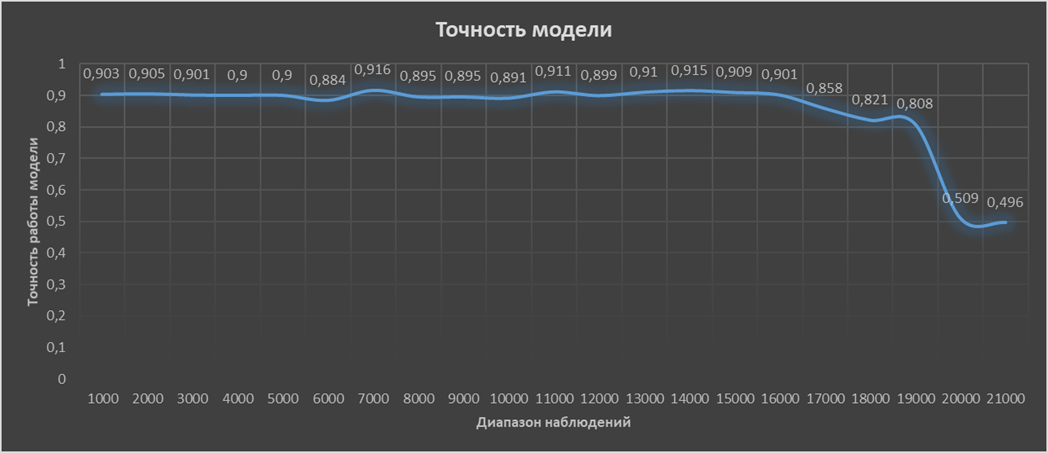

Мы наблюдаем, что модель отлично прогнозирует результаты на тестовой выборке, если в ней находятся наблюдения с 1 по 16 000 (соответствует временному диапазоне с сентября 2017 г. по январь 2022 г.).

В диапазоне с 16 000 до 19 000 (февраль 2022 г. по декабрь 2022 г.) точность предсказаний модели несколько снижается, но все равно остается на приемлемом уровне. 

После этого модель фактически перестает работать. 


На графиках распределения переменных мы наблюдаем, что в диапазоне после 16 000 наблюдений увеличивается разброс в значениях большинства переменных. Также предположительно в период после декабря 2022 г. на валютный ранок начали оказывать влияния новые факторы, которые не позволяют модели эффективно осуществлять прогнозирование.


В настоящий момент найти методы, позволяющие повысить эффективность работы модели на временном интервале после декабря 2022 г. не удалось.